# Importing libraries and beautification functions for plots/plotly plots

In [4]:
import sys
sys.path.append("../utils/")
import data_generation_and_treatment as dgen
import d2p2_sequence_analysis as d2p2
from Bio import SeqIO
import cluster_tools as ct
import class_sequence as cs
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from localcider.sequenceParameters import SequenceParameters

import xlsxwriter
import os
# import plotly
# import plotly.graph_objs as go
# import plotly.offline as py
# import plotly.tools as tls
# plotly.offline.init_notebook_mode(connected=True)
import re

In [3]:
import matplotlib; mpl =matplotlib
mpl.rcParams['figure.figsize'] = (12.0,9.0) # default = (6.0, 4.0)
mpl.rcParams['font.size']      = 28        # default = 10

mpl.rcParams['axes.linewidth']    = 0.75 # default = 1.0
mpl.rcParams['lines.linewidth']   = 1.5 # default = 1.0
mpl.rcParams['patch.linewidth']   = 1.0 # default = 1.0
mpl.rcParams['grid.linewidth']    = 0.5 # default = 0.5
mpl.rcParams['xtick.major.width'] = 1.0 # default = 0.5
mpl.rcParams['xtick.minor.width'] = 0.0 # default = 0.5
mpl.rcParams['ytick.major.width'] = 1.0 # default = 0.5
mpl.rcParams['ytick.minor.width'] = 0.0 # default = 0.5


def make_nice_axis(ax):
    """ Function to beautify axis, based on version written by D. Murakowski"""

    ax.spines['top'].set_visible(False) # hide top axs
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 30))
    ax.spines['left'].set_position(('outward', 30))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(pad=10)
    ax.yaxis.set_tick_params(pad=10)
    ax.xaxis.set_tick_params(labelsize=24)
    ax.yaxis.set_tick_params(labelsize=24)
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 20
    
    
def plotly_beautify(plotly_fig):
    plotly_fig['layout']['xaxis1']['showline'] = True
    plotly_fig['layout']['yaxis1']['showline'] = True
    plotly_fig['layout']['xaxis1']['showgrid'] = True
    plotly_fig['layout']['yaxis1']['showgrid'] = True
    plotly_fig['layout']['showlegend'] = True

# Input file for sorted data in the following format:

### - Protein ID
### - List of IDR ids (',' is delimiter)
### - Sequence
### - Gene name
### - List of IDR start positions (-1 if no disorder)(',' is delimiter)
### - List of IDR end positions (-1 if no disorder)(',' is delimiter)
### - List of PFAM ID's (PFAMID_START_END_ESCORE_DESCRIPTION)(',' is delimiter)

# Read input function, and make a copy to calculate changes to D2P2 file

In [14]:
input_file_name = '../data/raw_sequence_data/collapsed_data_d2p2_nuclear_proteins.csv'
df = pd.read_csv(input_file_name);
df_original = df.copy();

# Exclude IDRs from PFAM domains, linkers, and stitch small IDRs together

In [15]:
d2p2.exclude_idrs_pfams(df)

Total IDRs excluded are 5877


In [16]:
linker_gap = 45;
d2p2.exclude_linker_idrs(df,linker_gap=linker_gap)

Total linker IDRs are 457


In [17]:
stitch_gap =12;
d2p2.stitch_idrs(df,stitch_gap)

Total IDRs stitched is 16358


In [18]:
bf = (df_original['idr_start'].values=='-1').sum()
af= (df['idr_start'].values=='-1').sum()
print('Number of proteins without IDRs before {} and after {} filtering'.format(bf,af))

Number of proteins without IDRs before 1317 and after 1522 filtering


# Write out filtered data into FASTA file

In [19]:
output_data = '../data/featurized_data_matrix/filtered_sequences'
output_data = output_data + '_linker_' + str(linker_gap) + '_stitch_' + str(stitch_gap) +'.fasta'
d2p2.write_idr_file(df,output_data)

# Generate data matrix from scratch

In [31]:
# output_data = 'treated_data/20190709/filtered_sequences_linker_45_stitch_12.fasta'
filtered_filename= dgen.generate_filtered_file(output_data, 40) #filters seqs < 40 AAs long
print(filtered_filename)
Motif_filename = '../data/motif_list/SLiMS-All.txt'

coarse_graining = 3 #considers as a block only if 2 aas out of 6 belong to the group of interactions in question
write_file_path ='../data/featurized_data_matrix/coarse_graining_' + str(coarse_graining) + '_new_aa_groups'
try:
    # Create target Directory
    os.mkdir(write_file_path)
    print("Directory " , write_file_path ,  " Created ")
except:
    print("Directory " + write_file_path +  " already exists")
    
custom_aa_list=True
aa_group=[['E','D'], ['R','K'], ['Q','N','S','T','G','H', 'C'], ['A','L','M','I','V'], ['F','Y','W'], ['P']]
aa_group_names=['NC','PC','Po','Apo','Aro','Pro']

flag_save_files = 1
indices_to_delete = [];
use_all_features =1;
data_matrix, all_seqs_ids = dgen.generate_data_matrix([filtered_filename], 1, Motif_filename, use_all_features, coarse_graining, write_file_path, indices_to_delete, flag_save_files, custom_aa_list=custom_aa_list,aa_group=aa_group,aa_group_names=aa_group_names)

FileNotFoundError: [Errno 2] No such file or directory: '../data/featurized_data_matrix/filtered_sequences_linker_45_stitch_12.fasta'

# If reading directly from csv

In [23]:
csv_file = write_file_path + '/data_matrix/consolidated_data_matrix.csv'
data_matrix = pd.read_csv(csv_file,index_col=0)
all_seqs_ids = data_matrix.index;

In [26]:
# files = ['protein_lists/TFs_Vaquerizas_Uniprot_Reviewed.txt','protein_lists/Speckles_Saitoh_Spector_2004.xlsx','protein_lists/Nucleolus_Anderson_Mann_2005.xlsx','protein_lists/Stress_Granule_Jain_Parker_2016.xlsx','protein_lists/Pbody_Hubstenberger_2017.xlsx'];
# files = ['protein_lists/Clean_CO_GO_list.txt','protein_lists/heterochromatin_GO_list.txt'];
files = ['../data/protein_lists_in_compartments/TFs_Vaquerizas_Uniprot_Reviewed.txt','../data/protein_lists_in_compartments/Transcriptional_coactivators_GO_list.txt']

# label_legends = ['others','tfs','speckles','nucleolus','stress','pbody','overlap']
# label_legends = ['others','coactivators','heterochromatin','overlap']
label_legends = ['others','tfs','coactivators','overlap']

colors = ['#d3d3d3','#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','black'];

dgen.add_labels_to_data_matrix(data_matrix=data_matrix,GO_list_files=files,all_seqs_ids_in_DM=all_seqs_ids,overlap_label=-1)

,f-NC,f-PC,f-Po,f-Apo,f-Aro,f-Pro,NC-P_small,NC-P_medium,NC-P_large,NC-l_avg,...,DEG_Nend_UBRbox_3,DEG_Nend_UBRbox_4,DEG_ODPH_VHL_1,DEG_SCF_FBW7_1,DEG_SCF_FBW7_2,DEG_SCF_SKP2-CKS1_1,DEG_SCF_TRCP1_1,DEG_SIAH_1,DEG_SPOP_SBC_1,label
sequence id,,,,,,,,,,,,,,,,,,,,,
A0A024RCV8_1_1_45|A0A024RCV8_HUMAN|A0A024RCV8_HUMAN,0.355556,0.200000,0.088889,0.355556,0.155556,0.200000,0.500000,0.250000,0.250000,3.500000,...,0,0,0,0,0,0,0,0,0,0
A0A075B6F0_4_235_380|A0A075B6F0_HUMAN|A0A075B6F0_HUMAN,0.328767,0.116438,0.102740,0.260274,0.267123,0.184932,0.636364,0.272727,0.090909,3.818182,...,0,0,0,0,0,0,0,0,0,0
A0A075B6F0_5_399_501|A0A075B6F0_HUMAN|A0A075B6F0_HUMAN,0.359223,0.106796,0.087379,0.262136,0.262136,0.184466,0.750000,0.000000,0.250000,8.500000,...,0,0,0,0,0,0,0,0,0,0
A0A075B6F0_7_576_756|A0A075B6F0_HUMAN|A0A075B6F0_HUMAN,0.403315,0.082873,0.138122,0.265193,0.215470,0.160221,0.736842,0.157895,0.105263,4.210526,...,0,0,0,0,0,0,0,0,0,0
A0A075B6F0_10_868_913|A0A075B6F0_HUMAN|A0A075B6F0_HUMAN,0.347826,0.108696,0.195652,0.326087,0.173913,0.173913,0.250000,0.250000,0.500000,3.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6Y1_13_1169_1321|CMTA1_HUMAN|CMTA1_HUMAN,0.294118,0.130719,0.137255,0.372549,0.307190,0.130719,0.444444,0.222222,0.333333,3.666667,...,0,0,0,0,0,0,0,0,0,1
U3KQK1_1_72_125|U3KQK1_HUMAN|U3KQK1_HUMAN,0.500000,0.018519,0.259259,0.333333,0.166667,0.055556,0.666667,0.000000,0.333333,10.666667,...,0,0,0,0,0,0,0,0,0,0
X6RCR8_1_119_167|X6RCR8_HUMAN|X6RCR8_HUMAN,0.204082,0.224490,0.183673,0.448980,0.306122,0.081633,0.500000,0.000000,0.500000,3.500000,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# data_matrix.iloc[:,-1].values[data_matrix.iloc[:,-1].values==len(files)+1] = 0;
data_matrix.iloc[:,-1].values[data_matrix.iloc[:,-1].values==-1]=len(files)+1;

In [29]:
data_matrix.to_csv(csv_file)

# Filter by size

In [13]:
lengths = np.array([int(x.split('_')[3].split('|')[0]) -int(x.split('_')[2]) for x in list(data_matrix.index)])
threshold_length = 50;
data_matrix = data_matrix.drop(data_matrix.index[np.where(lengths<=threshold_length)[0]],axis=0)
data_matrix


,f-NC,f-PC,f-Po,f-Apo,f-Aro,f-Pro,NC-P_small,NC-P_medium,NC-P_large,NC-l_avg,...,DEG_Nend_UBRbox_3,DEG_Nend_UBRbox_4,DEG_ODPH_VHL_1,DEG_SCF_FBW7_1,DEG_SCF_FBW7_2,DEG_SCF_SKP2-CKS1_1,DEG_SCF_TRCP1_1,DEG_SIAH_1,DEG_SPOP_SBC_1,label
sequence id,,,,,,,,,,,,,,,,,,,,,
A0A087WVF3_1_343_440|TBC3D_HUMAN|TBC3D_HUMAN,0.357143,0.051020,0.163265,0.234694,0.224490,0.204082,0.500000,0.000000,0.500000,44.500000,...,0,0,0,0,0,0,0,0,1,0
A0A087WXS9_1_343_440|TBC3I_HUMAN|TBC3I_HUMAN,0.357143,0.051020,0.163265,0.234694,0.224490,0.204082,0.500000,0.000000,0.500000,44.500000,...,0,0,0,0,0,0,0,0,1,0
A0A0U1RRE5_1_1_68|NBDY_HUMAN|NBDY_HUMAN,0.323529,0.073529,0.147059,0.220588,0.220588,0.235294,0.000000,0.500000,0.500000,28.500000,...,0,0,0,0,0,0,0,0,0,0
A0A183_1_1_80|LCE6A_HUMAN|LCE6A_HUMAN,0.200000,0.087500,0.200000,0.375000,0.375000,0.137500,0.400000,0.200000,0.400000,11.600000,...,0,0,0,0,0,0,0,0,0,0
A0AVK6_6_451_622|E2F8_HUMAN|E2F8_HUMAN,0.348837,0.087209,0.133721,0.232558,0.302326,0.127907,0.500000,0.250000,0.250000,39.500000,...,1,0,0,0,0,0,0,0,0,0
A0AVK6_9_755_813|E2F8_HUMAN|E2F8_HUMAN,0.406780,0.050847,0.033898,0.288136,0.355932,0.152542,0.000000,0.000000,1.000000,53.000000,...,0,0,0,0,0,0,0,0,0,0
A0FGR9_2_590_677|ESYT3_HUMAN|ESYT3_HUMAN,0.272727,0.136364,0.125000,0.238636,0.318182,0.147727,0.500000,0.250000,0.250000,18.500000,...,0,0,0,0,0,0,0,0,0,0
A0MZ66_5_314_631|SHOT1_HUMAN|SHOT1_HUMAN,0.270440,0.166667,0.172956,0.327044,0.276730,0.113208,0.625000,0.250000,0.125000,16.500000,...,0,0,0,0,0,0,0,0,1,0
A0PJY2_3_423_475|FEZF1_HUMAN|FEZF1_HUMAN,0.320755,0.056604,0.075472,0.245283,0.226415,0.320755,0.000000,0.500000,0.500000,23.000000,...,0,0,0,0,1,0,0,0,0,0


In [14]:
# This is just to remove all the "double" features
double_bsd_feats = []
for col in data_matrix:
    if col.split('-')[0] in aa_group_names and col.split('-')[1] in aa_group_names:
        double_bsd_feats.append(col)

data_matrix = data_matrix.drop(double_bsd_feats,axis=1)
labels = data_matrix['label']

In [15]:
data_matrix

,f-NC,f-PC,f-Po,f-Apo,f-Aro,f-Pro,NC-P_small,NC-P_medium,NC-P_large,NC-l_avg,...,DEG_Nend_UBRbox_3,DEG_Nend_UBRbox_4,DEG_ODPH_VHL_1,DEG_SCF_FBW7_1,DEG_SCF_FBW7_2,DEG_SCF_SKP2-CKS1_1,DEG_SCF_TRCP1_1,DEG_SIAH_1,DEG_SPOP_SBC_1,label
sequence id,,,,,,,,,,,,,,,,,,,,,
A0A087WVF3_1_343_440|TBC3D_HUMAN|TBC3D_HUMAN,0.357143,0.051020,0.163265,0.234694,0.224490,0.204082,0.500000,0.000000,0.500000,44.500000,...,0,0,0,0,0,0,0,0,1,0
A0A087WXS9_1_343_440|TBC3I_HUMAN|TBC3I_HUMAN,0.357143,0.051020,0.163265,0.234694,0.224490,0.204082,0.500000,0.000000,0.500000,44.500000,...,0,0,0,0,0,0,0,0,1,0
A0A0U1RRE5_1_1_68|NBDY_HUMAN|NBDY_HUMAN,0.323529,0.073529,0.147059,0.220588,0.220588,0.235294,0.000000,0.500000,0.500000,28.500000,...,0,0,0,0,0,0,0,0,0,0
A0A183_1_1_80|LCE6A_HUMAN|LCE6A_HUMAN,0.200000,0.087500,0.200000,0.375000,0.375000,0.137500,0.400000,0.200000,0.400000,11.600000,...,0,0,0,0,0,0,0,0,0,0
A0AVK6_6_451_622|E2F8_HUMAN|E2F8_HUMAN,0.348837,0.087209,0.133721,0.232558,0.302326,0.127907,0.500000,0.250000,0.250000,39.500000,...,1,0,0,0,0,0,0,0,0,0
A0AVK6_9_755_813|E2F8_HUMAN|E2F8_HUMAN,0.406780,0.050847,0.033898,0.288136,0.355932,0.152542,0.000000,0.000000,1.000000,53.000000,...,0,0,0,0,0,0,0,0,0,0
A0FGR9_2_590_677|ESYT3_HUMAN|ESYT3_HUMAN,0.272727,0.136364,0.125000,0.238636,0.318182,0.147727,0.500000,0.250000,0.250000,18.500000,...,0,0,0,0,0,0,0,0,0,0
A0MZ66_5_314_631|SHOT1_HUMAN|SHOT1_HUMAN,0.270440,0.166667,0.172956,0.327044,0.276730,0.113208,0.625000,0.250000,0.125000,16.500000,...,0,0,0,0,0,0,0,0,1,0
A0PJY2_3_423_475|FEZF1_HUMAN|FEZF1_HUMAN,0.320755,0.056604,0.075472,0.245283,0.226415,0.320755,0.000000,0.500000,0.500000,23.000000,...,0,0,0,0,1,0,0,0,0,0


# Find number of eigen-values of interest from denoising spectra

Eigen values greater than 2*1.2072914294880834 are 4


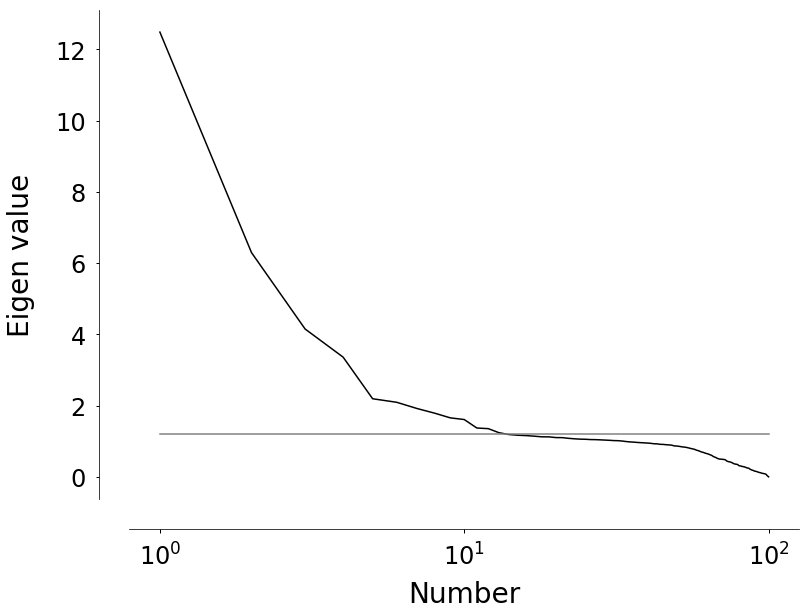

/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:522: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.

/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:522: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



In [49]:
(eig_vals,eig_vecs,pc_scores)= ct.PCA_analysis(data_matrix.iloc[:,:-1].values,centered=True,clean_matrix=False,clean_threshold=2.0,write_PC_scores=True,write_path=write_file_path+'/data_matrix')
fig,axes =plt.subplots()
make_nice_axis(axes)
q = data_matrix.iloc[:,:-1].values.shape[0]/(data_matrix.iloc[:,:-1].values.shape[1]);
lambda_max = 1 + 1/q + 2/q**0.5;
print('Eigen values greater than 2*{} are {}'.format(lambda_max,np.where(eig_vals<2*lambda_max)[0][0]))
axes.plot(range(1,len(eig_vals)+1),eig_vals,Color='black')
axes.plot(range(1,len(eig_vals)+1),lambda_max*np.ones(len(eig_vals)),Color='grey')
axes.set_xscale('log')
axes.set_xlabel('Number')
axes.set_ylabel('Eigen value')
plt.show()

fig,axes =plt.subplots()
make_nice_axis(axes)
axes.plot(range(1,len(eig_vals)+1),np.cumsum(eig_vals)/sum(eig_vals)*100,Color='black')
axes.set_xlabel('Number')
axes.set_ylabel('% variance')
plotly_fig = tls.mpl_to_plotly(fig)
plotly_beautify(plotly_fig)
# py.plot(plotly_fig,filename=write_file_path+'/figures/interactive_prob_tSNE_'+str(tSNE_axis),auto_open=False)

py.iplot(plotly_fig)

In [50]:
key = np.argsort((abs(eig_vecs[:,0])))[::-1]
print(abs(eig_vecs[key[0:15],0]))
print(data_matrix.columns[key][0:15])

[0.2561556  0.24165417 0.23462553 0.22848128 0.21712091 0.20869286
 0.20575794 0.20421231 0.19689678 0.19338985 0.19322684 0.18855361
 0.18582035 0.18365517 0.17262425]
Index(['MOD_GSK3_1', 'MOD_CK1_1', 'MOD_ProDKin_1', 'DOC_USP7_MATH_1',
       'LIG_FHA_1', 'MOD_CK2_1', 'MOD_Plk_1', 'MOD_Plk_4',
       'LIG_14-3-3_CanoR_1', 'Aro-l_max', 'MOD_NEK2_1', 'DEG_SPOP_SBC_1',
       'MOD_PKA_2', 'MOD_PIKK_1', 'LIG_FHA_2'],
      dtype='object')


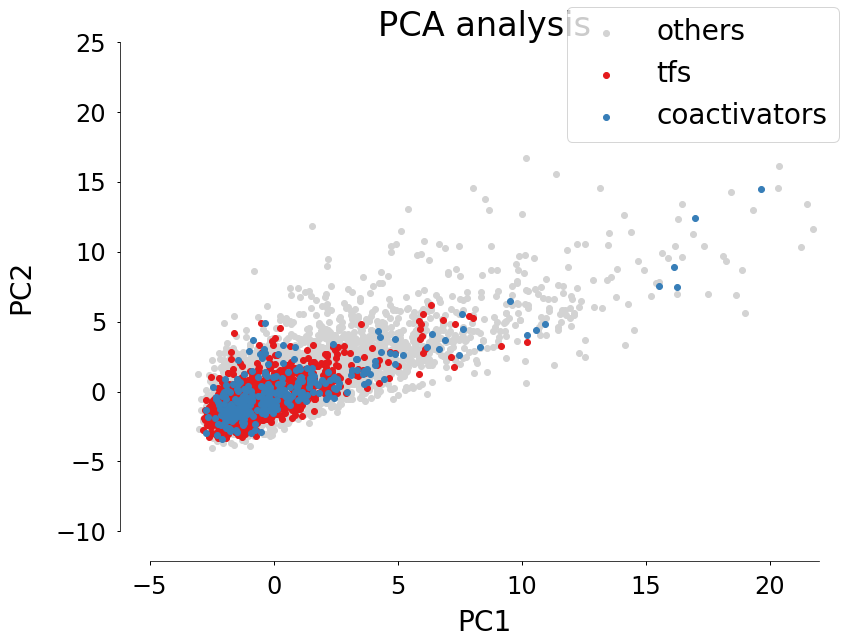

In [51]:
pc_int1=0;
pc_int2=1;
flag_save_files = 1

ax = ct.plot_PCA(pc_scores,T=data_matrix.iloc[:,-1],pc_int1=0,pc_int2=1,colors=colors,labels=label_legends,file_save=flag_save_files,write_path=write_file_path+'/figures_pca_unclean')
ax.set_xlim((-5,22))
ax.set_ylim((-10,25))

plt.show()

# tSNE projections

In [52]:
(Y) = ct.tSNE_projection(data_matrix.iloc[:,:-1].values,write_tSNE_scores=True,write_path=write_file_path + '/data_matrix')

In [53]:
Y = pd.read_csv(write_file_path+'/data_matrix/tSNE_ncomp_2_perp_50.csv',index_col=0)
Y = Y.values
Y

array([[ 22.420446 ,  -4.207055 ],
       [ 22.420835 ,  -4.207056 ],
       [ 16.750175 , -21.806057 ],
       ...,
       [ 51.289978 , -19.10226  ],
       [-28.140667 ,   4.9768524],
       [-24.328    , -39.38022  ]])

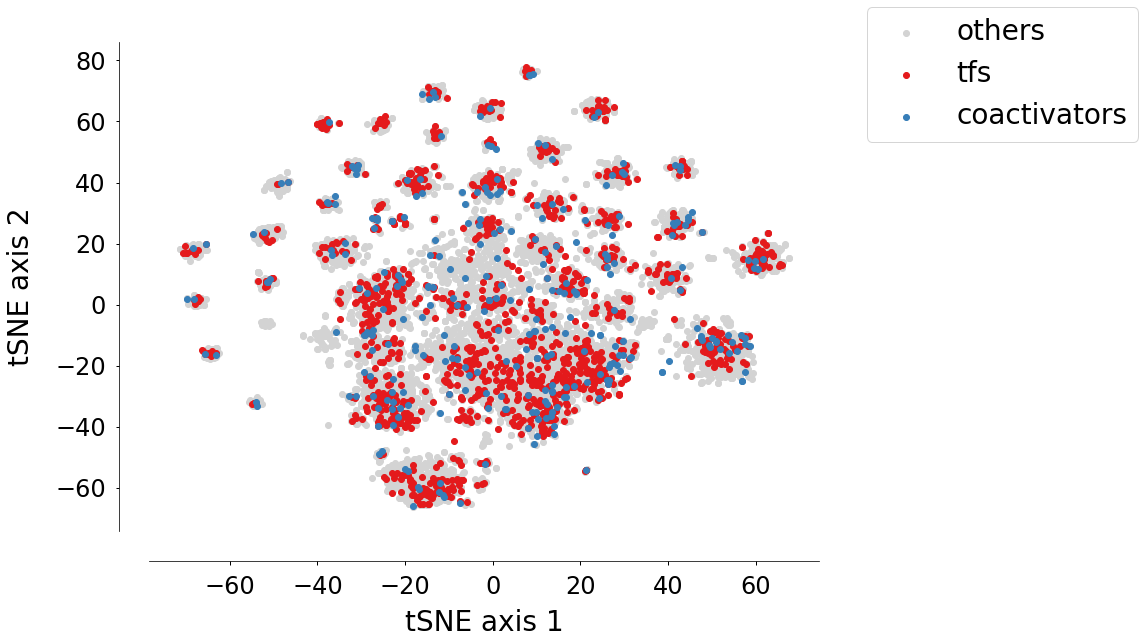

In [54]:
ax = ct.plot_tSNE(Y,T=data_matrix.iloc[:,-1],ax1=0,ax2=1,colors=colors,labels=label_legends,file_save=flag_save_files,write_path=write_file_path+'/figures_tSNE')
# ax.set_xlim((-35,35))
# ax.set_ylim((-25,40))

plt.show()

# plot variation along tSNE axes

In [55]:
label_lists =[1,2,3]
tSNE_axis =0
label_other =0


labels_others = np.where(data_matrix.iloc[:,-1]==label_other)[0]
fig,axes = plt.subplots()
nbins = 20;
bin_range = np.linspace(min(Y[:,tSNE_axis]),max(Y[:,tSNE_axis]),nbins)
make_nice_axis(axes)

values,bins = np.histogram(Y[labels_others,tSNE_axis],bins=bin_range,density=True)
axes.plot(bins[:-1],values,alpha=1,label=label_legends[label_other] + '(' + str(len(labels_others)) + ')',color=colors[label_other]);

for label in label_lists:
    labels = np.where(data_matrix.iloc[:,-1]==label)[0]
    values,bins  = np.histogram(Y[labels,tSNE_axis],bins=bin_range,density=True)
    axes.plot(bins[:-1],values,alpha=0.5,label=label_legends[label]+ '(' + str(len(labels)) + ')',color=colors[label]);

# axes.legend(bbox_to_anchor=(1.05,1.1))
axes.set_xlabel('tSNE_'+ str(tSNE_axis+1))
axes.set_ylabel('probability')
# plt.show()
plotly_fig = tls.mpl_to_plotly(fig)
plotly_beautify(plotly_fig)
py.plot(plotly_fig,filename=write_file_path+'/figures_tSNE/interactive_prob_tSNE_'+str(tSNE_axis),auto_open=False)

py.iplot(plotly_fig)

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:823: RuntimeWarning:

invalid value encountered in true_divide

/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:522: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.

/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:522: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.

/anacon

# Clustering

In [56]:
n_pcs = 20;
n_clusters=15;

(Z,T) = ct.hierarchical_cluster(pc_scores[:,0:n_pcs],n_clusters=n_clusters,optimal_ordering=False)

In [57]:
# Re-labeling clusters (C1 = biggest cluster, C2 = second biggest ...):

ind_clust = [list(np.where(T==i+1)[0]) for i in range(0, n_clusters)]

clust_sizes = [len(i) for i in ind_clust]
clust_sizes = np.array(clust_sizes)

new_clust_sizes = np.argsort(clust_sizes)
new_clust_sizes = new_clust_sizes[::-1]

new_clust_labels = [i*0 for i in range(0,len(T))]

clust_count = 1
for i in new_clust_sizes:
    for j in ind_clust[i]:
        new_clust_labels[j] = clust_count
    clust_count += 1

cluster_labels = np.array(new_clust_labels)

In [58]:
colors = ['#d3d3d3','#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','orange','black'];

protein_labels = data_matrix.iloc[:,-1];
fig,axes = plt.subplots()
make_nice_axis(axes)

for label_for_enriched_protein in range(len(label_legends)):
    tf_all = len(np.where(protein_labels==label_for_enriched_protein)[0])
    seq_all = len(protein_labels);
    print(label_legends[label_for_enriched_protein],tf_all,seq_all)
    
    if tf_all != 0 or label_legends[label_for_enriched_protein] != 'overlap':
        csize = [];
        cenrichment = [];
        for i in range(n_clusters):

            indices_clusters = np.where(cluster_labels==i+1)[0]
            csize.append(len(np.where(cluster_labels==i+1)[0]))

            tf_enrichment = len(np.where(protein_labels[indices_clusters]==label_for_enriched_protein)[0])/tf_all
            cluster_size =len(indices_clusters)/seq_all;

            cenrichment.append(tf_enrichment/cluster_size);


        key = np.argsort(np.array(csize))[::-1]
        axes.scatter(np.array(csize)[key]/seq_all*100,np.array(cenrichment)[key],color=colors[label_for_enriched_protein],label=label_legends[label_for_enriched_protein])
        axes.set_ylabel('fold enrichments')
        axes.set_xlabel('Cluster % size')

# axes.plot(range(20),np.ones((20,1)))
plotly_fig = tls.mpl_to_plotly(fig)
count = 0;
for x in plotly_fig['data']:
    x['name'] = label_legends[count]
    count +=1
    
plotly_beautify(plotly_fig)
# py.plot(plotly_fig,filename=write_file_path+'/figures/interactive_prob_tSNE_'+str(tSNE_axis),auto_open=False)

py.iplot(plotly_fig)
# plt.show()

others 8578 10251
tfs 1369 10251
coactivators 304 10251
overlap 0 10251


/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/renderer.py:522: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



In [59]:
max(data_matrix.iloc[:,-1])

2

Directory results/coarse_graining_1_new_aa_groups/clustering_results/Cluster_Purity_ already exists
[1.410e+02 3.340e+02 1.760e+03 1.932e+03 3.148e+03 6.910e+02 9.000e+00
 2.000e+00 6.500e+01 2.000e+00 3.600e+01 5.010e+02 1.800e+01 6.990e+02
 9.130e+02]
Directory results/coarse_graining_1_new_aa_groups/figures/clustering_results/Scatter_fold_enrichment_ already exists


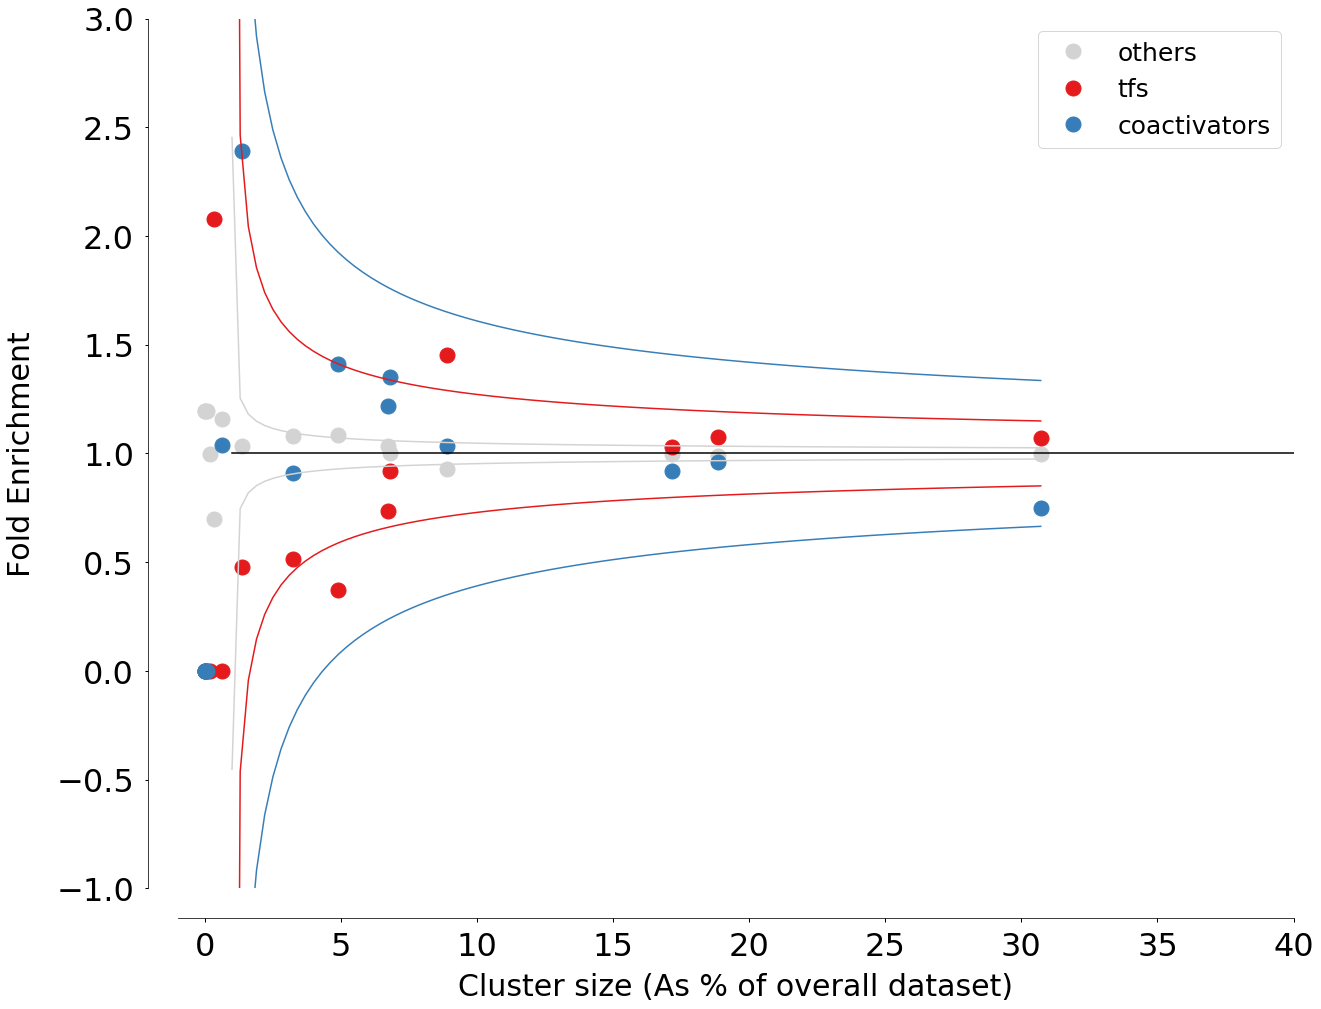

In [62]:
n_pcs = 20
n_clusters = 15

labels = data_matrix.iloc[:,-1]
# if max(labels) > len(files):
#     labels.values[labels.values==len(files)+1]=0;

graph_labels = label_legends
graph_labels = [i for i in label_legends if i != 'overlap']

xlim=(-1,40)
ylim=(-1,3)

# Clustering after dim reduction using PCA:
clust_labels_PCA = dgen.cluster_reduced_matrix(pc_scores, labels, n_pcs, n_clusters, write_file_path, flag_save_files, 1)
# dgen.generate_purity_plots(write_file_path, graph_labels, flag_save_files, 1, n_pcs, n_clusters)
dgen.plot_enrichment_vs_cluster_size(write_file_path, data_matrix, labels, graph_labels, colors, xlim, ylim, 1, flag_save_files, n_pcs, n_clusters)

# # Clustering after dim reduction using t-SNE: 
# clust_labels_tSNE = dgen.cluster_reduced_matrix(Y, labels, 2, n_clusters, write_file_path, flag_save_files, 2)
# dgen.generate_purity_plots(write_file_path, graph_labels, flag_save_files, 2, 2, n_clusters)
# dgen.plot_enrichment_vs_cluster_size(write_file_path, data_matrix, graph_labels, colors, 2, flag_save_files, 2, n_clusters)

(10251, 2)
(10251,)
Cluster 1 is 3148
Cluster 2 is 1932
Cluster 3 is 1760
Cluster 4 is 913
Cluster 5 is 699
Cluster 6 is 691
Cluster 7 is 501
Cluster 8 is 334
Cluster 9 is 141
Cluster 10 is 65
Cluster 11 is 36
Cluster 12 is 18
Cluster 13 is 9
Cluster 14 is 2
Cluster 15 is 2


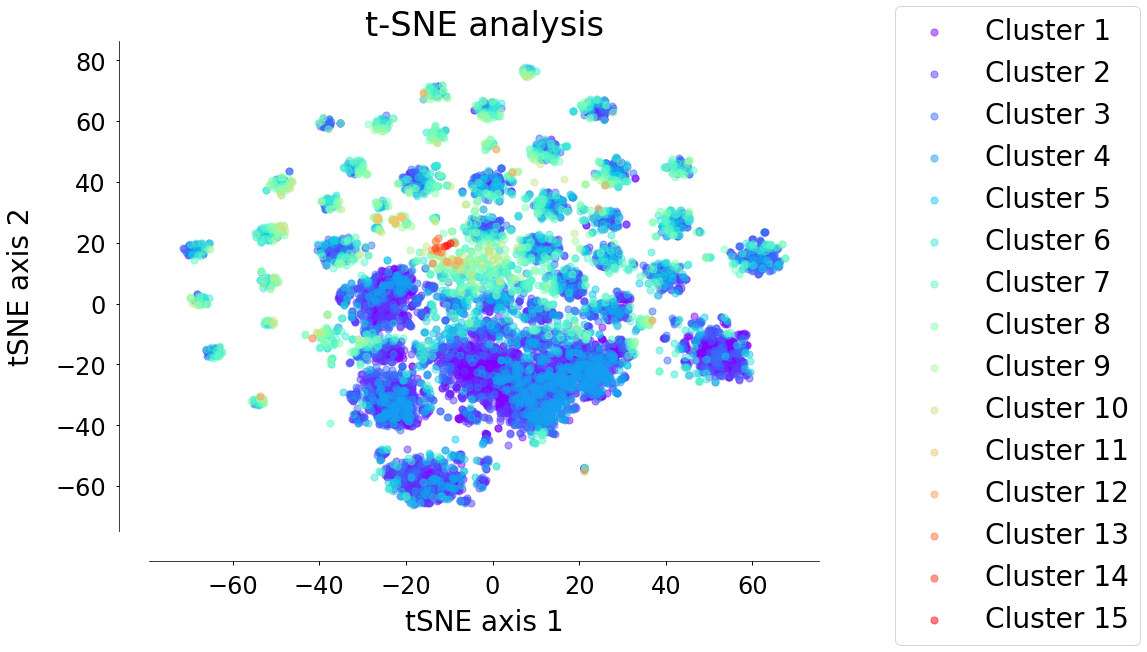

In [63]:
import matplotlib.cm as cm

ax1 =0;
ax2 =1;

print(Y.shape)
print(T.shape)

figure_tsne,ax = plt.subplots(1,1);
make_nice_axis(ax)

labels=['Cluster ' + str(i) for i in range(1,n_clusters+1)]
colors_for_clusters = (cm.rainbow(np.linspace(0, 1, n_clusters)))

for i in range(n_clusters):
    indices_clusters = np.where(cluster_labels==i+1)[0]
    print('Cluster {} is {}'.format(i+1,len(indices_clusters)))
    ax.scatter(Y[indices_clusters,ax1],Y[indices_clusters,ax2],color=colors_for_clusters[i],s=50,label=labels[i],alpha=0.5)

ax.axis('tight')
ax.set_xlabel('tSNE axis ' +str(ax1+1))
ax.set_ylabel('tSNE axis ' +str(ax2+1))
ax.set_title("t-SNE analysis")

ax.legend(bbox_to_anchor=(1.5,1.1))

file_save = False;
if file_save:
    file_name =  folder_name +'tSNE_with_inferred_clusters/tSNE_reversed_pc_' + str(ax1+1) + '_' + str(ax2+1)
    os.makedirs(os.path.dirname(file_name),exist_ok=True);
    figure_tsne.savefig(file_name+'.svg',format='svg',dpi=600,bbox_inches='tight')
    figure_tsne.savefig(file_name+'.png',format='png',dpi=600,bbox_inches='tight')

plt.show()

# plot enrichment of features for a given cluster

In [65]:
fig,ax = plt.subplots(1,1);
make_nice_axis(ax)

labels=list(data_matrix.columns[:-1])
colors_for_clusters = (cm.rainbow(np.linspace(0, 1, n_clusters)))
cluster_of_interest = 4;
indices_clusters = np.where(cluster_labels==cluster_of_interest)[0]
fe_clust_feature = [];
for i in range(len(labels)):
    fe_clust_feature.append(np.mean(data_matrix.iloc[indices_clusters,i].values)/np.mean(data_matrix.iloc[:,i].values))
    
fe_clust_feature = np.array(fe_clust_feature);
key = np.argsort(fe_clust_feature)[::-1]
ax.plot(np.array(labels)[key],fe_clust_feature[key])

ax.axis('tight')

plotly_fig = tls.mpl_to_plotly(fig)
plotly_beautify(plotly_fig)
# py.plot(plotly_fig,filename=write_file_path+'/figures/interactive_prob_tSNE_'+str(tSNE_axis),auto_open=False)

py.iplot(plotly_fig)

# Pairwise correlation matrix and plot

In [47]:
DM_cols=list(data_matrix.columns)
DM_cols
col_drop=[i for i in DM_cols if (i.split('-')[0] in aa_group_names) and ((i.split('-')[1].split('_')[0]=='P') or len(i.split('_'))>2)]
col_drop

data_matrix = data_matrix.drop(col_drop,axis=1)
data_matrix

,f-NC,f-PC,f-Po,f-Apo,f-Aro,f-Pro,NC-l_avg,NC-l_max,PC-l_avg,PC-l_max,...,DEG_Nend_UBRbox_3,DEG_Nend_UBRbox_4,DEG_ODPH_VHL_1,DEG_SCF_FBW7_1,DEG_SCF_FBW7_2,DEG_SCF_SKP2-CKS1_1,DEG_SCF_TRCP1_1,DEG_SIAH_1,DEG_SPOP_SBC_1,label
sequence id,,,,,,,,,,,,,,,,,,,,,
A0A087WVF3_1_343_440|TBC3D_HUMAN|TBC3D_HUMAN,0.357143,0.051020,0.163265,0.234694,0.224490,0.204082,44.500000,67,6.250000,7,...,0,0,0,0,0,0,0,0,1,0
A0A087WXS9_1_343_440|TBC3I_HUMAN|TBC3I_HUMAN,0.357143,0.051020,0.163265,0.234694,0.224490,0.204082,44.500000,67,6.250000,7,...,0,0,0,0,0,0,0,0,1,0
A0A0U1RRE5_1_1_68|NBDY_HUMAN|NBDY_HUMAN,0.323529,0.073529,0.147059,0.220588,0.220588,0.235294,28.500000,36,4.750000,9,...,0,0,0,0,0,0,0,0,0,0
A0A183_1_1_80|LCE6A_HUMAN|LCE6A_HUMAN,0.200000,0.087500,0.200000,0.375000,0.375000,0.137500,11.600000,25,6.000000,6,...,0,0,0,0,0,0,0,0,0,0
A0AVK6_6_451_622|E2F8_HUMAN|E2F8_HUMAN,0.348837,0.087209,0.133721,0.232558,0.302326,0.127907,39.500000,91,8.571429,18,...,1,0,0,0,0,0,0,0,0,0
A0AVK6_9_755_813|E2F8_HUMAN|E2F8_HUMAN,0.406780,0.050847,0.033898,0.288136,0.355932,0.152542,53.000000,53,6.000000,6,...,0,0,0,0,0,0,0,0,0,0
A0FGR9_2_590_677|ESYT3_HUMAN|ESYT3_HUMAN,0.272727,0.136364,0.125000,0.238636,0.318182,0.147727,18.500000,38,16.666667,24,...,0,0,0,0,0,0,0,0,0,0
A0MZ66_5_314_631|SHOT1_HUMAN|SHOT1_HUMAN,0.270440,0.166667,0.172956,0.327044,0.276730,0.113208,16.500000,50,14.307692,60,...,0,0,0,0,0,0,0,0,1,0
A0PJY2_3_423_475|FEZF1_HUMAN|FEZF1_HUMAN,0.320755,0.056604,0.075472,0.245283,0.226415,0.320755,23.000000,30,6.000000,10,...,0,0,0,0,1,0,0,0,0,0


Directory results/coarse_graining_1_new_aa_groups/figures/Feature_corr_matrix already exists


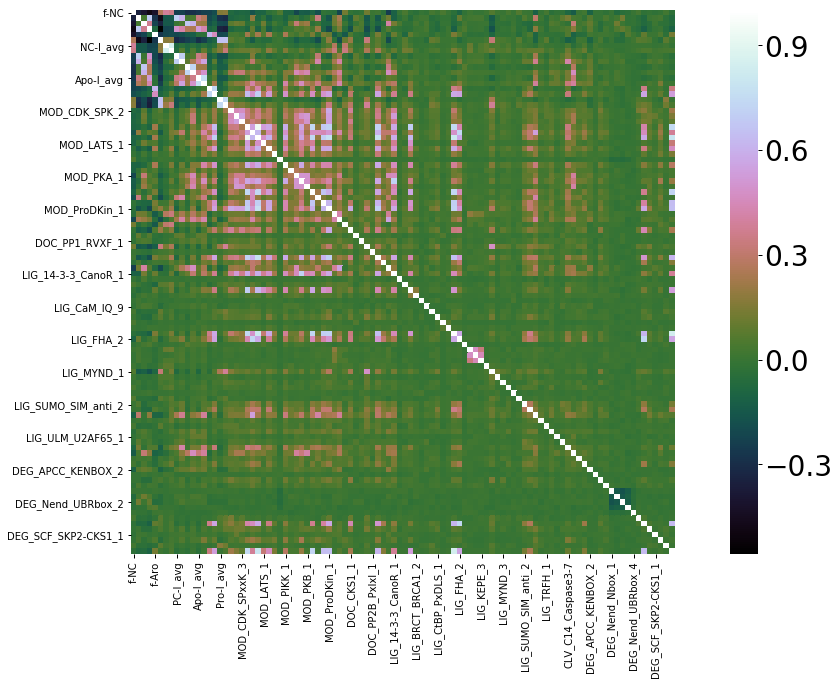

In [48]:
correlation_matrix = dgen.get_pairwise_corr(write_file_path, data_matrix, flag_save_files)


# Protein lists from clusters

In [31]:
data_matrix.index

Index(['A0A087WVF3_1_343_440|TBC3D_HUMAN|TBC3D_HUMAN',
       'A0A087WXS9_1_343_440|TBC3I_HUMAN|TBC3I_HUMAN',
       'A0A0U1RRE5_1_1_68|NBDY_HUMAN|NBDY_HUMAN',
       'A0A183_1_1_80|LCE6A_HUMAN|LCE6A_HUMAN',
       'A0AVK6_6_451_622|E2F8_HUMAN|E2F8_HUMAN',
       'A0AVK6_9_755_813|E2F8_HUMAN|E2F8_HUMAN',
       'A0FGR9_2_590_677|ESYT3_HUMAN|ESYT3_HUMAN',
       'A0MZ66_5_314_631|SHOT1_HUMAN|SHOT1_HUMAN',
       'A0PJY2_3_423_475|FEZF1_HUMAN|FEZF1_HUMAN',
       'A0PJZ3_1_32_92|GXLT2_HUMAN|GXLT2_HUMAN',
       ...
       'Q9Y6X2_1_72_124|PIAS3_HUMAN|PIAS3_HUMAN',
       'Q9Y6X4_2_269_670|F169A_HUMAN|F169A_HUMAN',
       'Q9Y6X6_2_1493_1775|MYO16_HUMAN|MYO16_HUMAN',
       'Q9Y6X8_1_1_55|ZHX2_HUMAN|ZHX2_HUMAN',
       'Q9Y6X8_2_157_212|ZHX2_HUMAN|ZHX2_HUMAN',
       'Q9Y6X8_6_748_837|ZHX2_HUMAN|ZHX2_HUMAN',
       'Q9Y6X9_2_530_797|MORC2_HUMAN|MORC2_HUMAN',
       'Q9Y6Y1_3_279_381|CMTA1_HUMAN|CMTA1_HUMAN',
       'Q9Y6Y1_13_1169_1321|CMTA1_HUMAN|CMTA1_HUMAN',
       'Q9Y6Y8_3_93_254|S23

In [32]:
dgen.get_prot_id_from_clust(write_file_path, data_matrix, label_legends, cluster_labels, all_seqs_ids, n_pcs, n_clusters, switch_PCA_tSNE = 1)

Directory results/coarse_graining_1_new_aa_groups/proteins in each cluster/ already exists


# Features fold enrichment

In [33]:
feat_fold_enrichment=dgen.get_feat_fold_enrichment(write_file_path, clust_labels_PCA, n_clusters, switch_PCA_tSNE=1)

import csv

fieldnames = []
for i in feat_fold_enrichment:
    fieldnames.append(i + ' fold enrich')
    fieldnames.append(i + ' feat name')

with open(write_file_path + '/proteins in each cluster/feat_fold_enrichment.csv', mode='w') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    for i in range(0, len(feat_fold_enrichment['C1'])):
        writer.writerow({
            'C1 fold enrich': feat_fold_enrichment['C1'][i][0], 
            'C1 feat name': feat_fold_enrichment['C1'][i][1],
            'C2 fold enrich': feat_fold_enrichment['C2'][i][0], 
            'C2 feat name': feat_fold_enrichment['C2'][i][1],
            'C3 fold enrich': feat_fold_enrichment['C3'][i][0], 
            'C3 feat name': feat_fold_enrichment['C3'][i][1],
            'C4 fold enrich': feat_fold_enrichment['C4'][i][0], 
            'C4 feat name': feat_fold_enrichment['C4'][i][1],
            'C5 fold enrich': feat_fold_enrichment['C5'][i][0], 
            'C5 feat name': feat_fold_enrichment['C5'][i][1],
            'C6 fold enrich': feat_fold_enrichment['C6'][i][0], 
            'C6 feat name': feat_fold_enrichment['C6'][i][1],
            'C7 fold enrich': feat_fold_enrichment['C7'][i][0], 
            'C7 feat name': feat_fold_enrichment['C7'][i][1],
            'C8 fold enrich': feat_fold_enrichment['C8'][i][0], 
            'C8 feat name': feat_fold_enrichment['C8'][i][1],
            'C9 fold enrich': feat_fold_enrichment['C9'][i][0], 
            'C9 feat name': feat_fold_enrichment['C9'][i][1],
            'C10 fold enrich': feat_fold_enrichment['C10'][i][0], 
            'C10 feat name': feat_fold_enrichment['C10'][i][1],
            'C11 fold enrich': feat_fold_enrichment['C11'][i][0], 
            'C11 feat name': feat_fold_enrichment['C11'][i][1],
            'C12 fold enrich': feat_fold_enrichment['C12'][i][0], 
            'C12 feat name': feat_fold_enrichment['C12'][i][1],
            'C13 fold enrich': feat_fold_enrichment['C13'][i][0], 
            'C13 feat name': feat_fold_enrichment['C13'][i][1],
            'C14 fold enrich': feat_fold_enrichment['C14'][i][0], 
            'C14 feat name': feat_fold_enrichment['C14'][i][1],
            'C15 fold enrich': feat_fold_enrichment['C15'][i][0], 
            'C15 feat name': feat_fold_enrichment['C15'][i][1]
        })
    

In [34]:
# for cluster in feat_fold_enrichment:
#     y_values = [i[0] for i in feat_fold_enrichment[cluster]]
#     x_values = [i[1] for i in feat_fold_enrichment[cluster]]
    
#     indices_clusters = np.where(cluster_labels==int(cluster.split('C')[1]))[0]
    
#     plt.bar(x_values, y_values, align='center', alpha=0.5)
#     plt.xticks(x_values, fontsize=8, rotation='vertical')
#     plt.ylabel('Fold enrichment')
#     plt.title('Features fold enrichment of {} (size: {})'.format(cluster, len(indices_clusters)))
#     plt.show()

feat_fold_enrichment['C1'][0][1]

'DEG_ODPH_VHL_1'

# BSD patterns for specific sequences

Directory results/coarse_graining_1_new_aa_groups/BRD4_IDR_1/ already exists
BRD4_IDR_1 : This IDR is 59 amino acids long


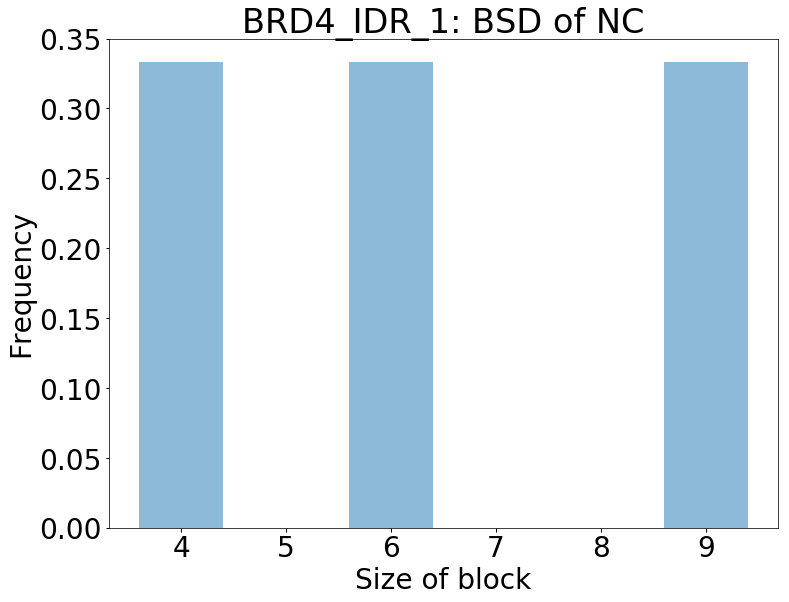

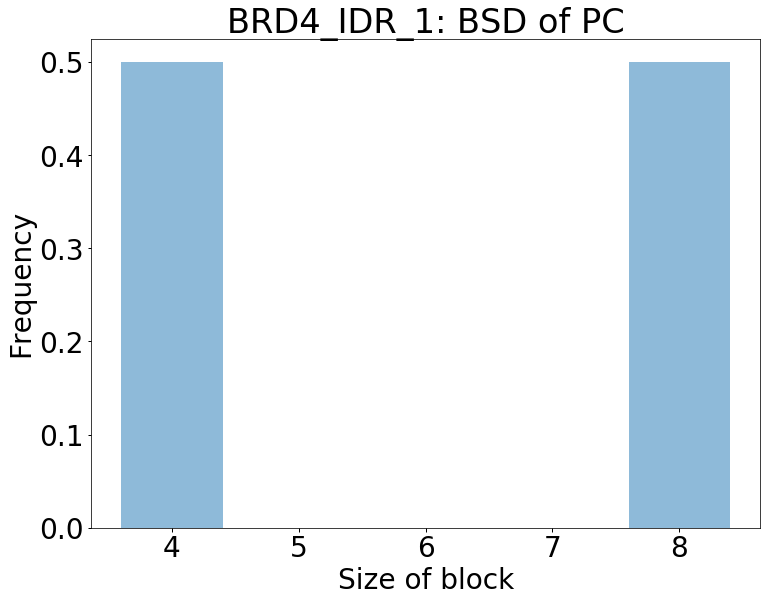

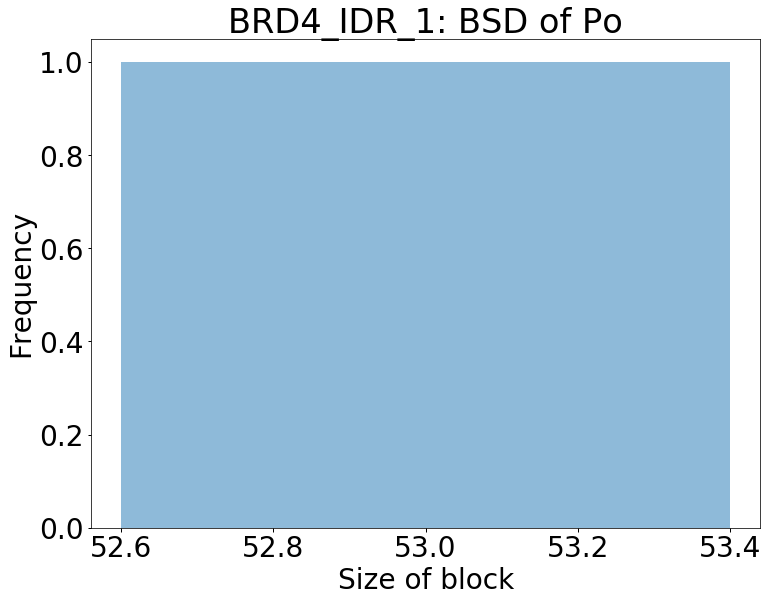

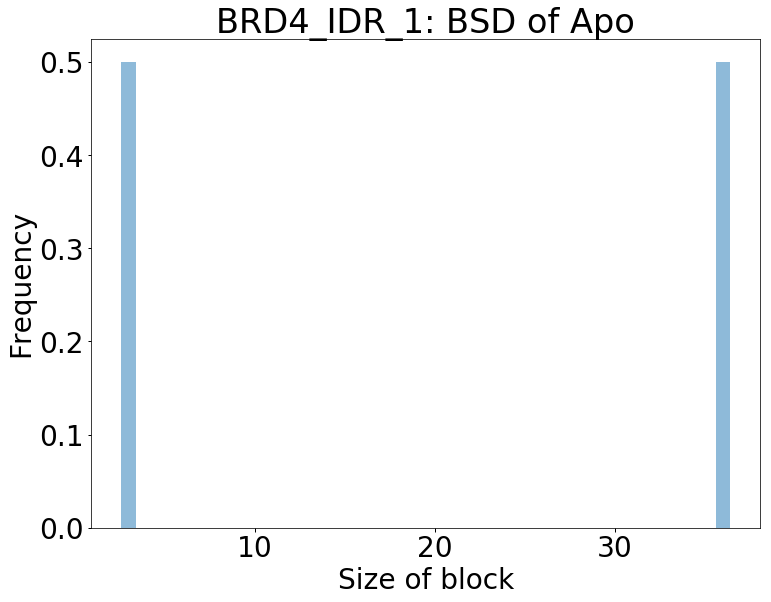

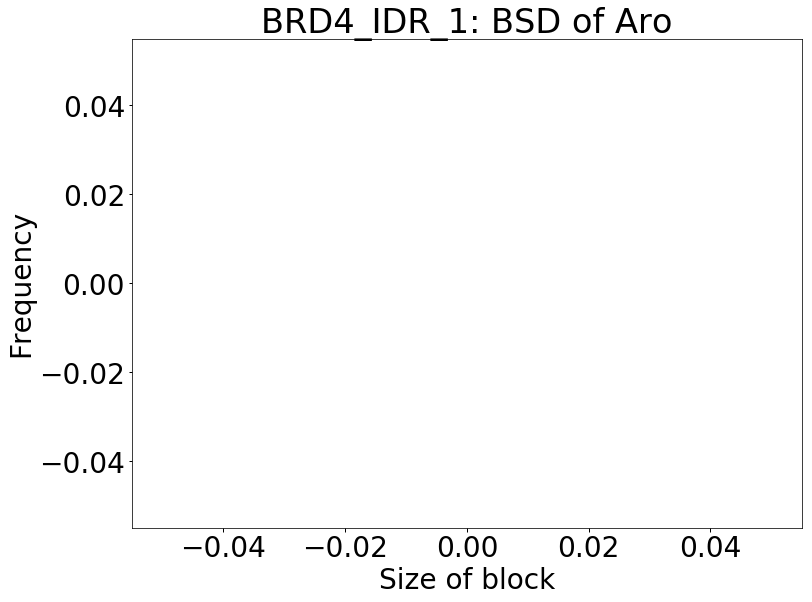

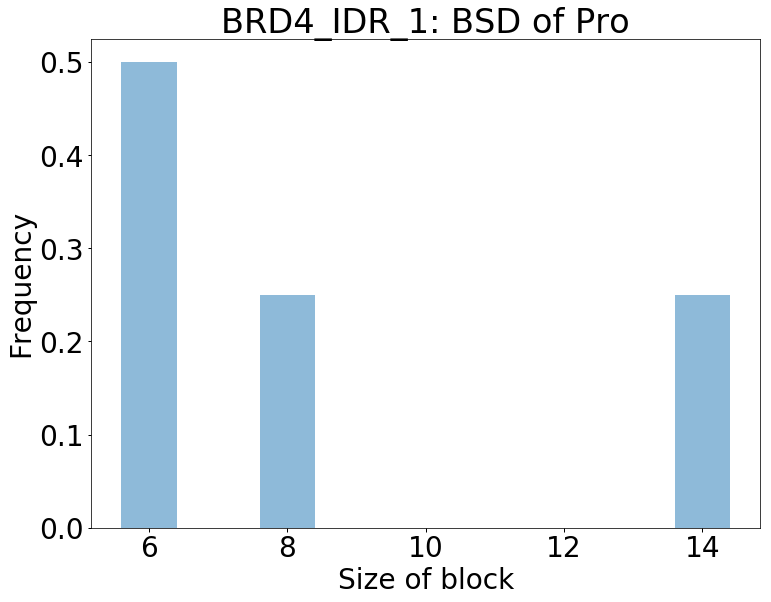

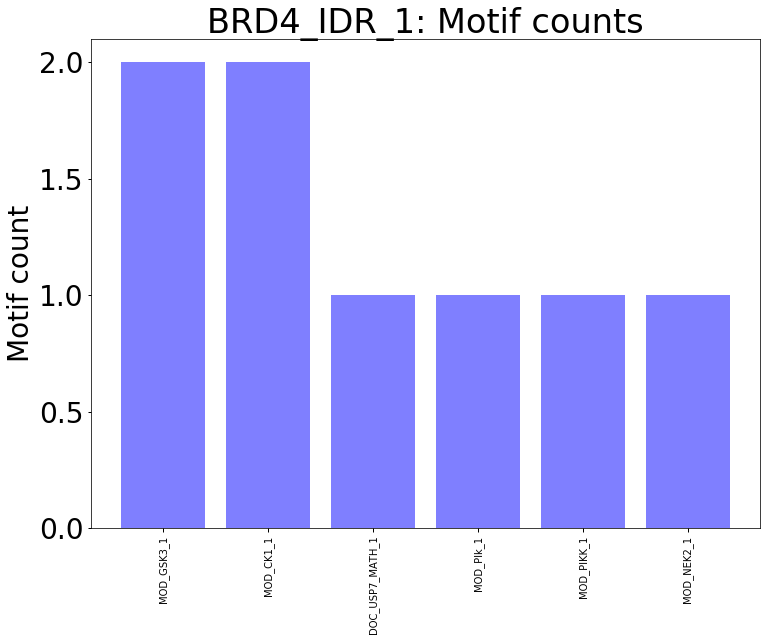

Directory results/coarse_graining_1_new_aa_groups/BRD4_IDR_2/ already exists
BRD4_IDR_2 : This IDR is 183 amino acids long


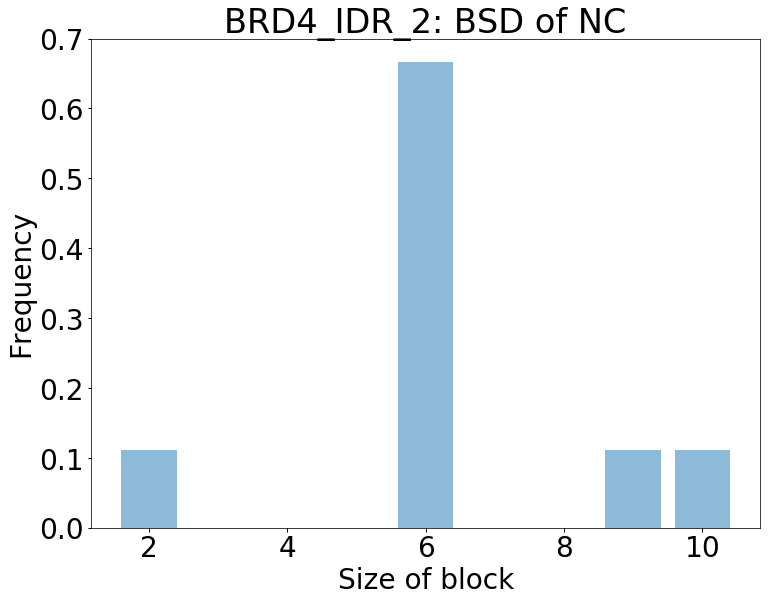

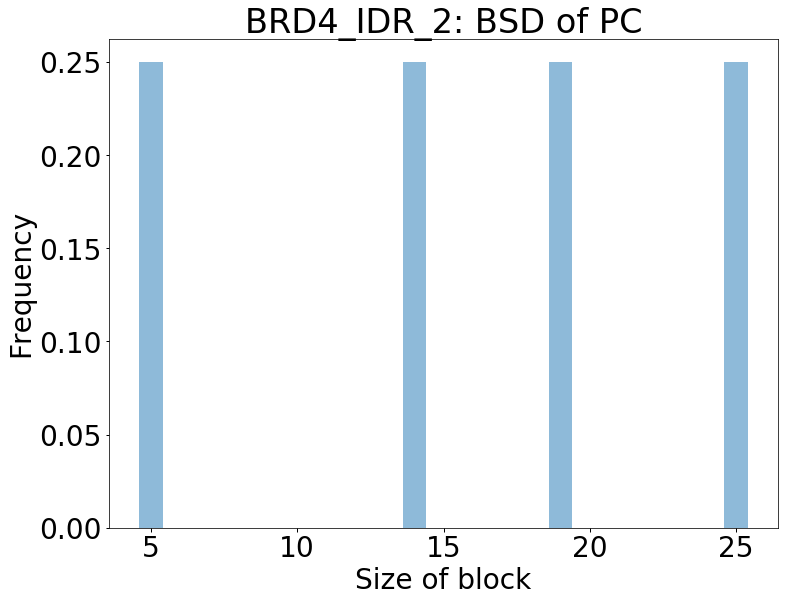

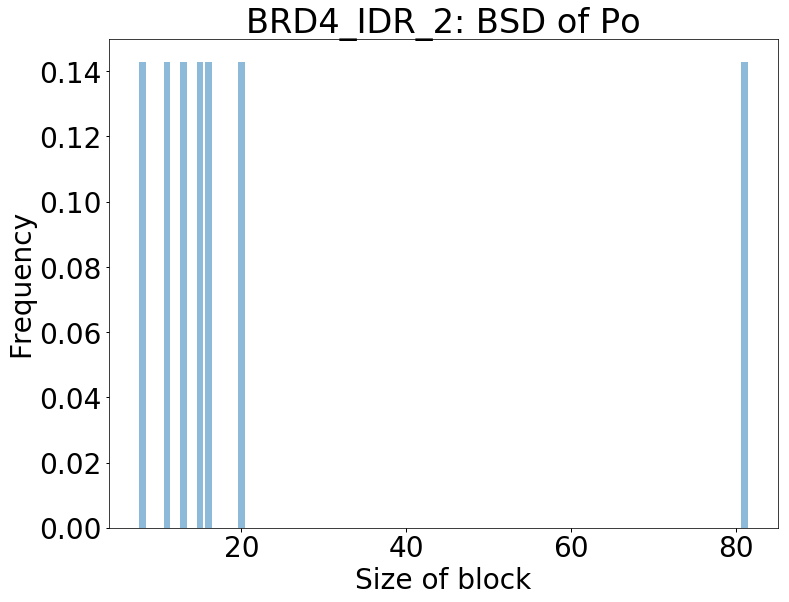

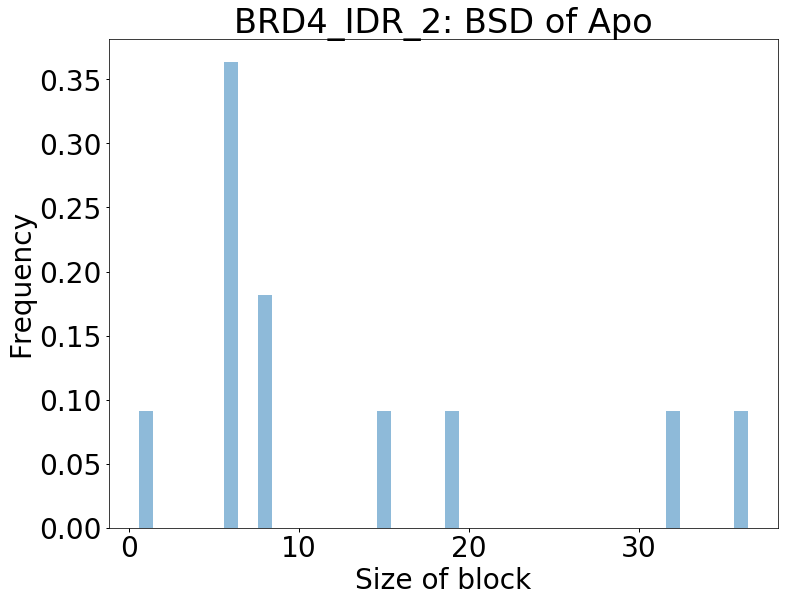

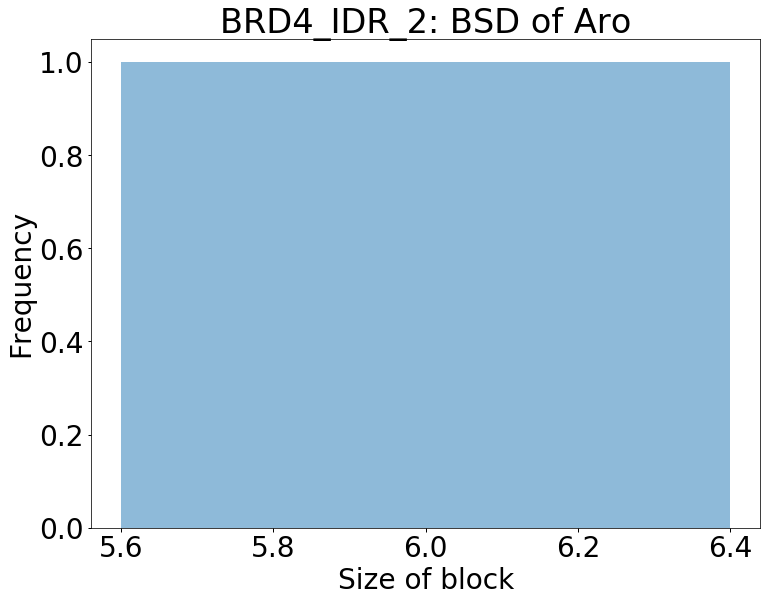

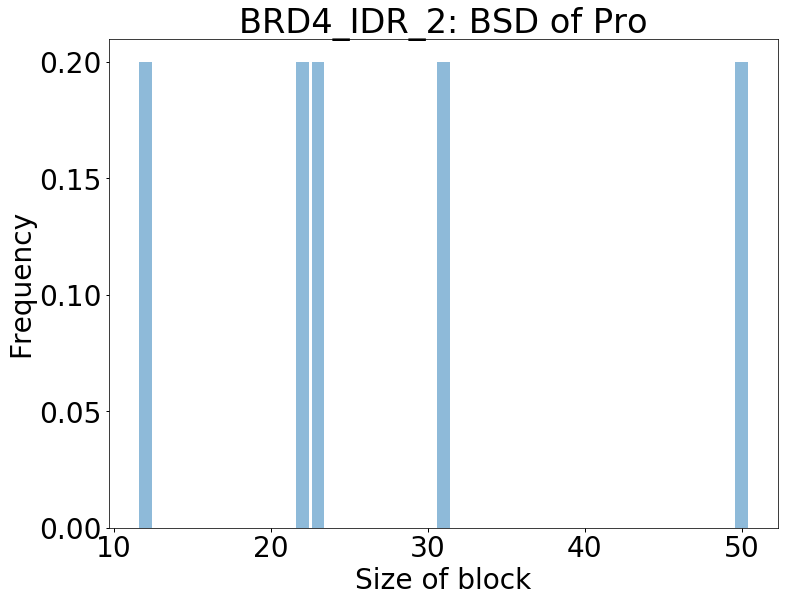

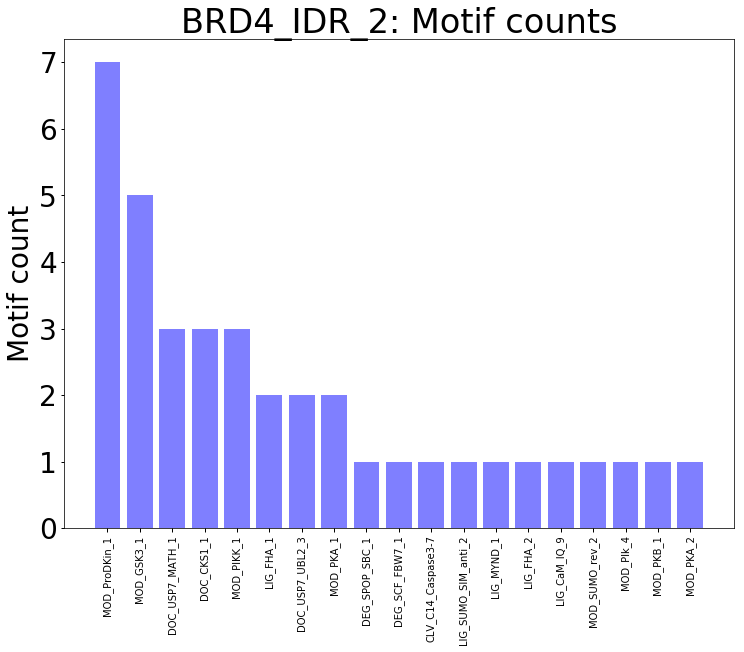

Directory results/coarse_graining_1_new_aa_groups/BRD4_IDR_3/ already exists
BRD4_IDR_3 : This IDR is 891 amino acids long


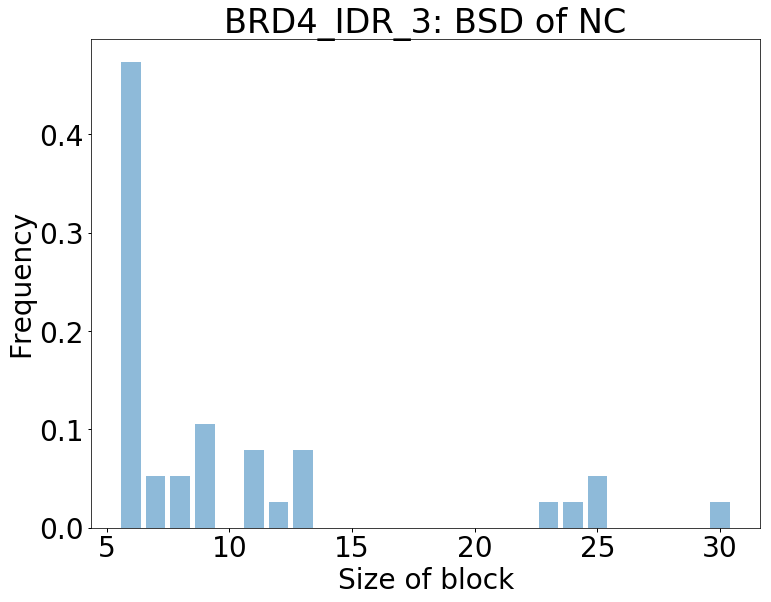

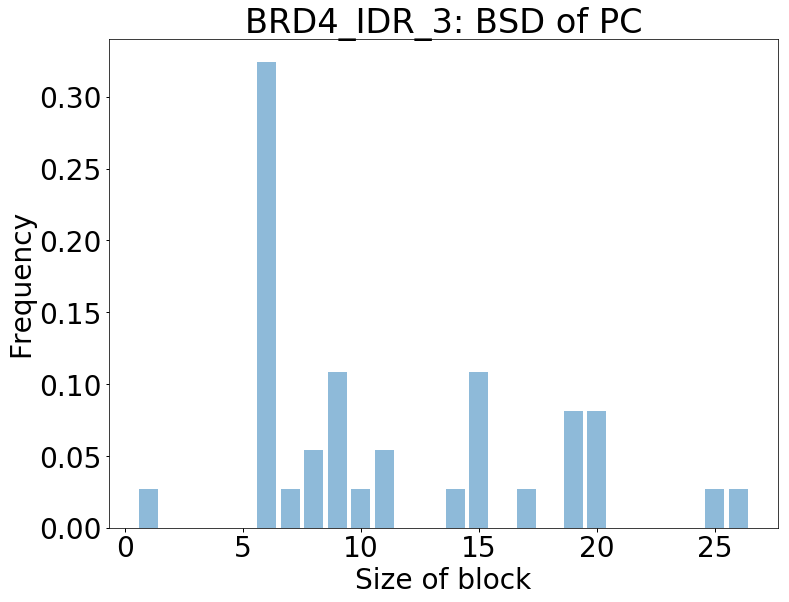

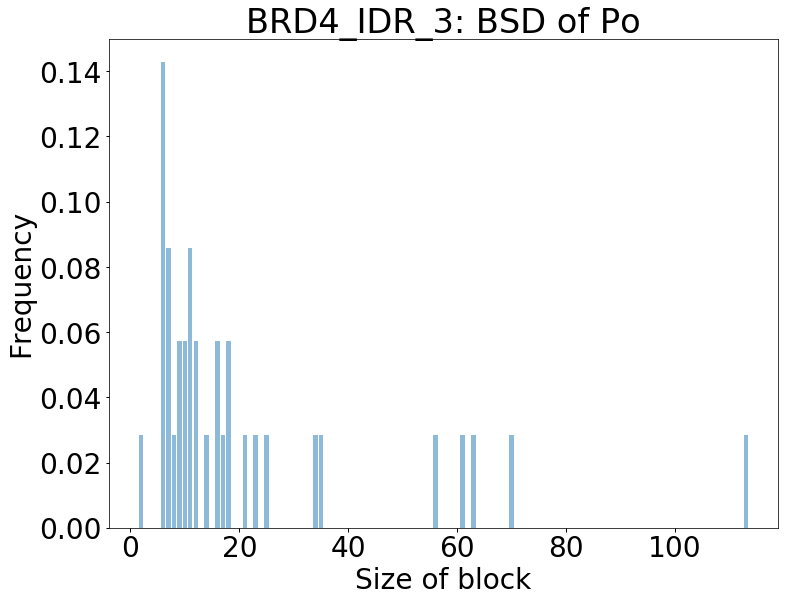

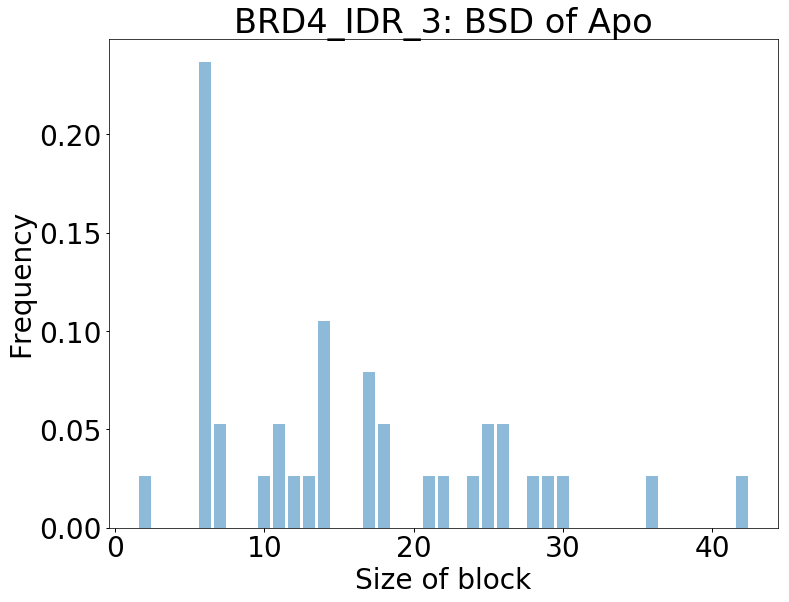

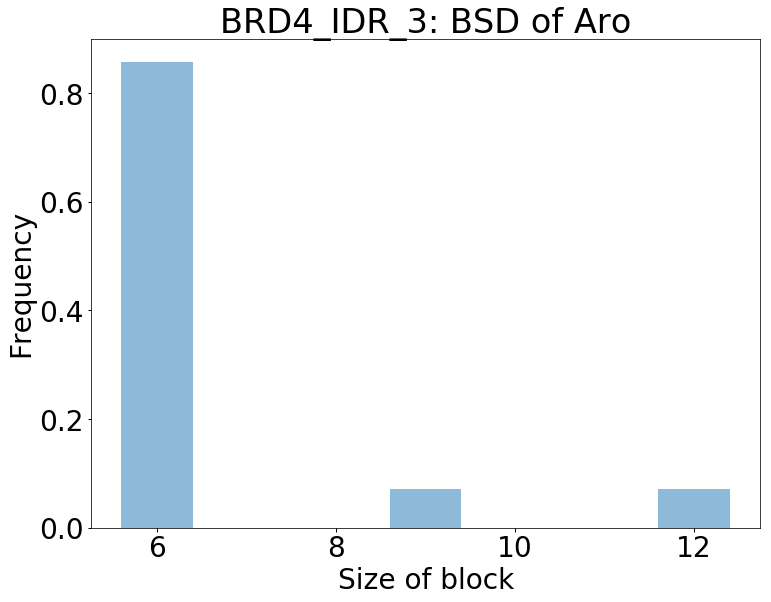

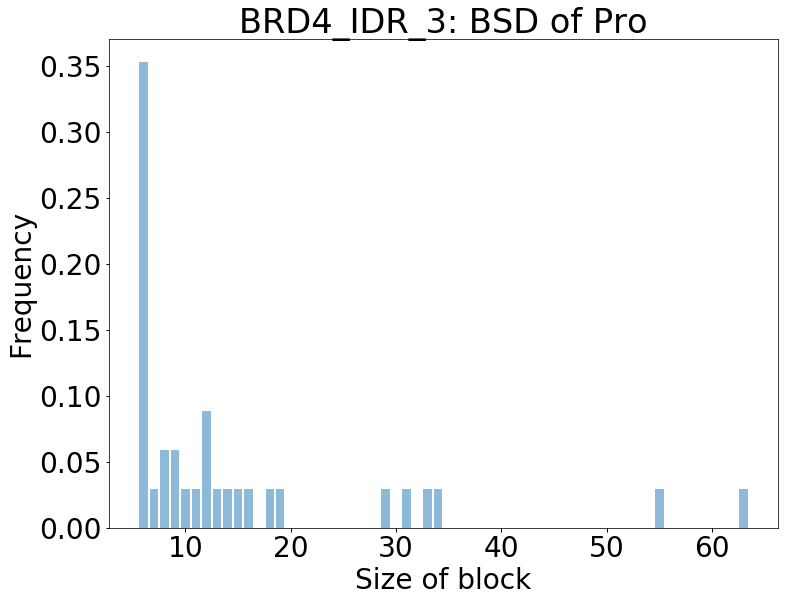

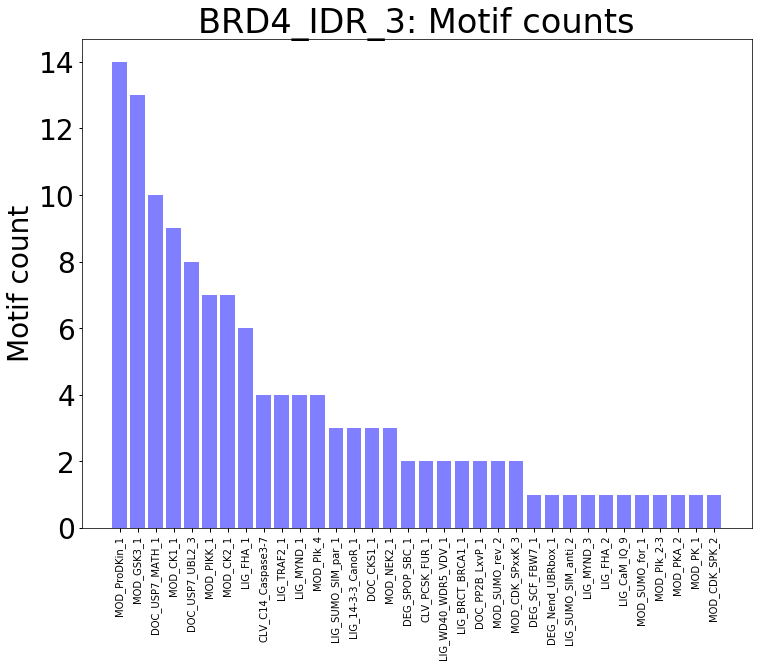

Directory results/coarse_graining_1_new_aa_groups/MECP2_IDR_1/ already exists
MECP2_IDR_1 : This IDR is 118 amino acids long


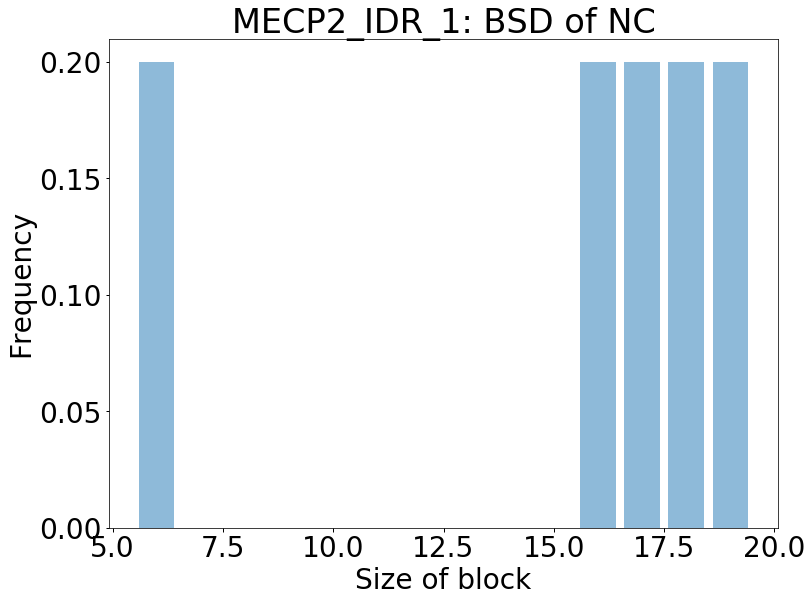

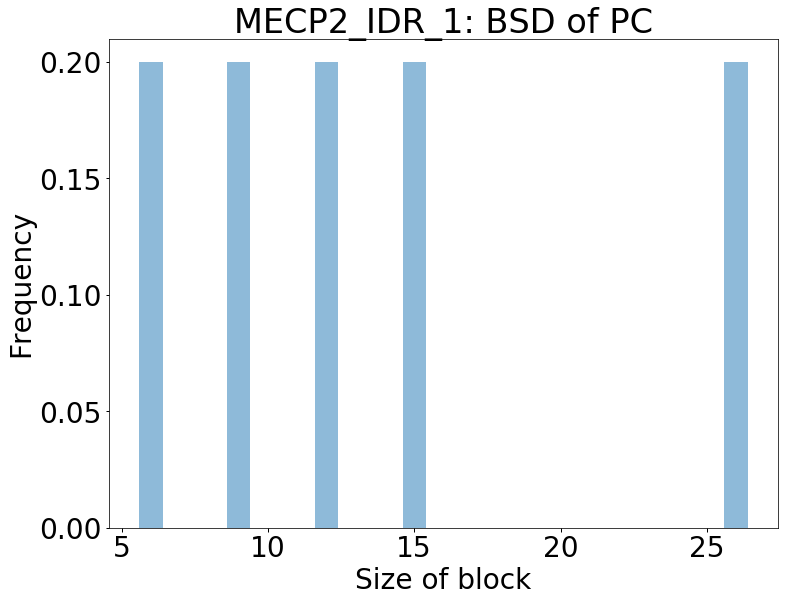

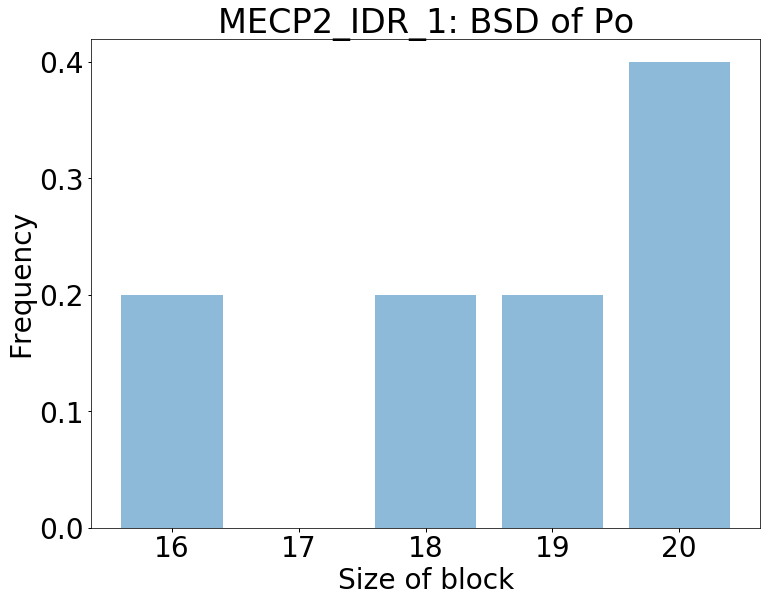

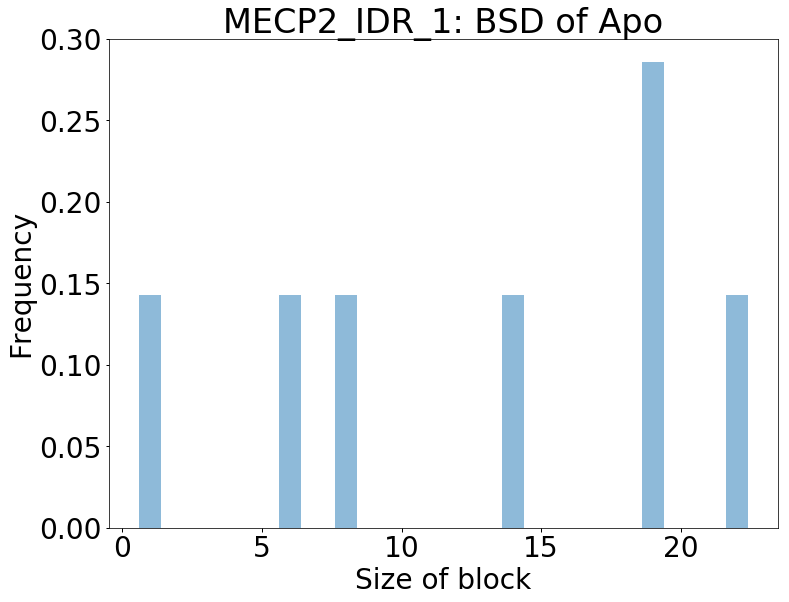

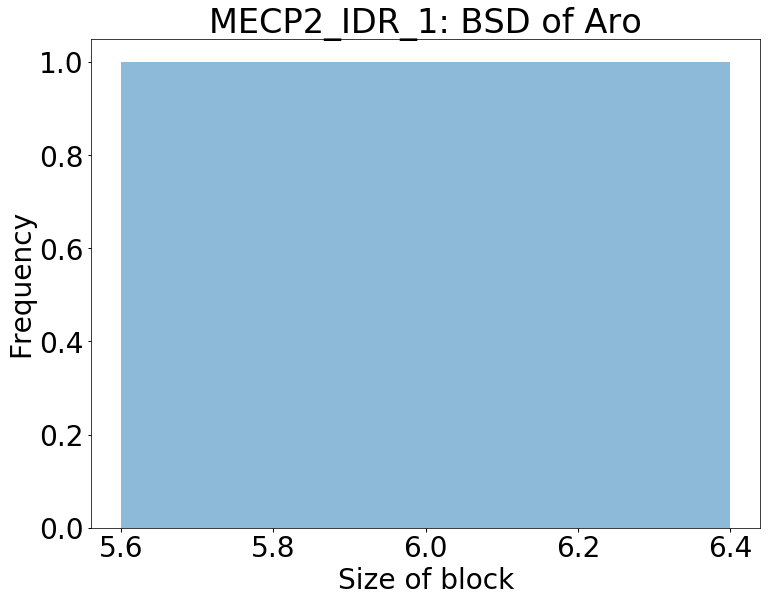

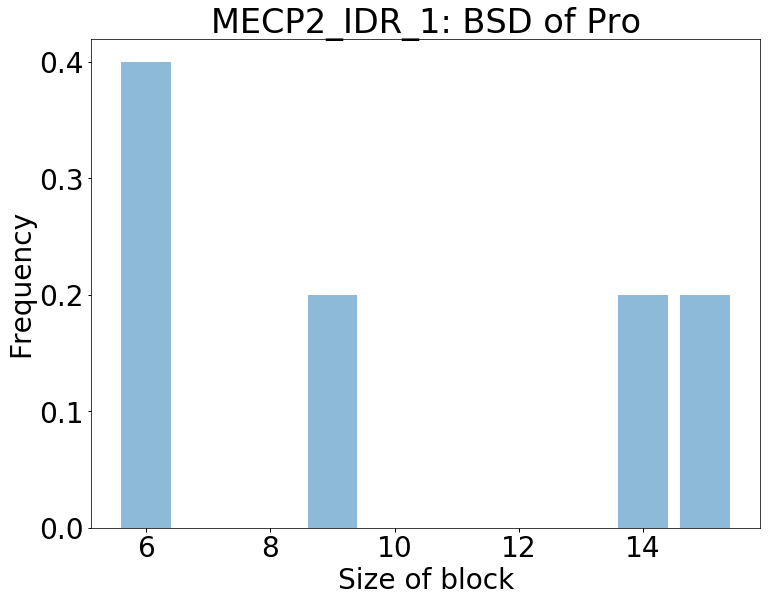

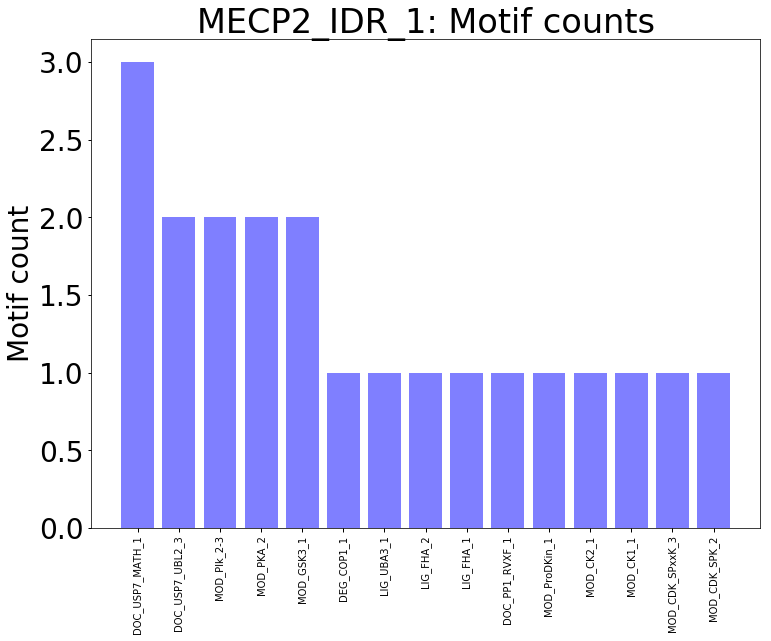

Directory results/coarse_graining_1_new_aa_groups/MECP2_IDR_2/ already exists
MECP2_IDR_2 : This IDR is 336 amino acids long


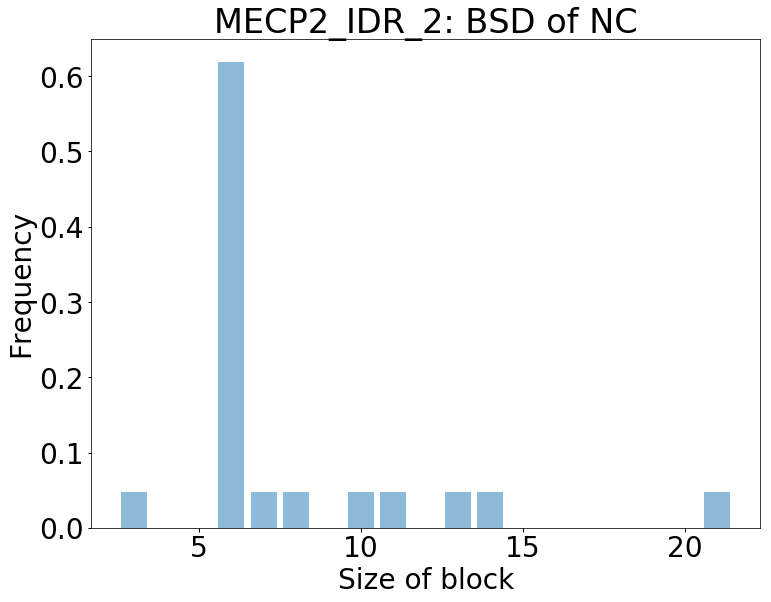

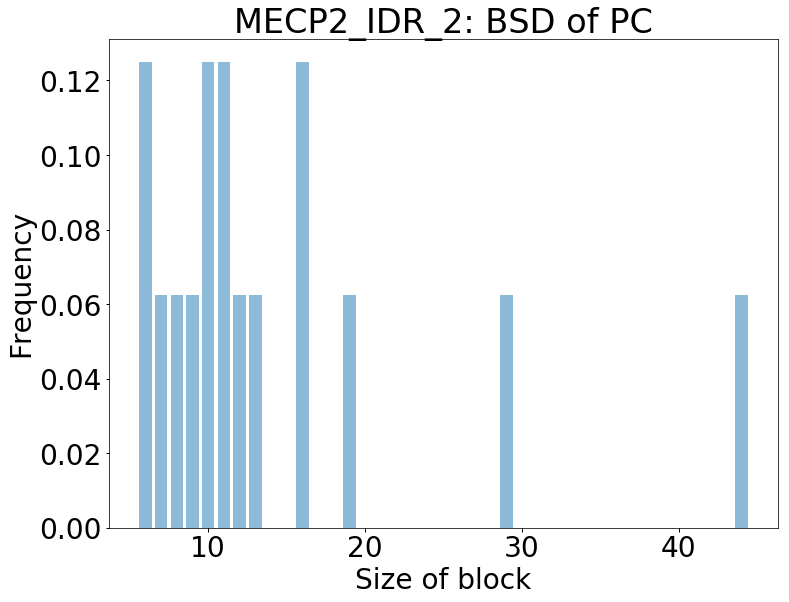

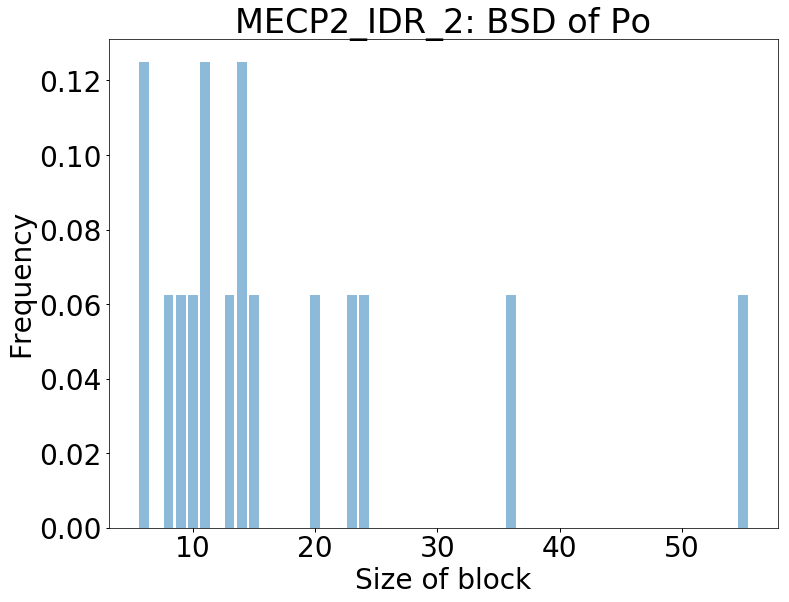

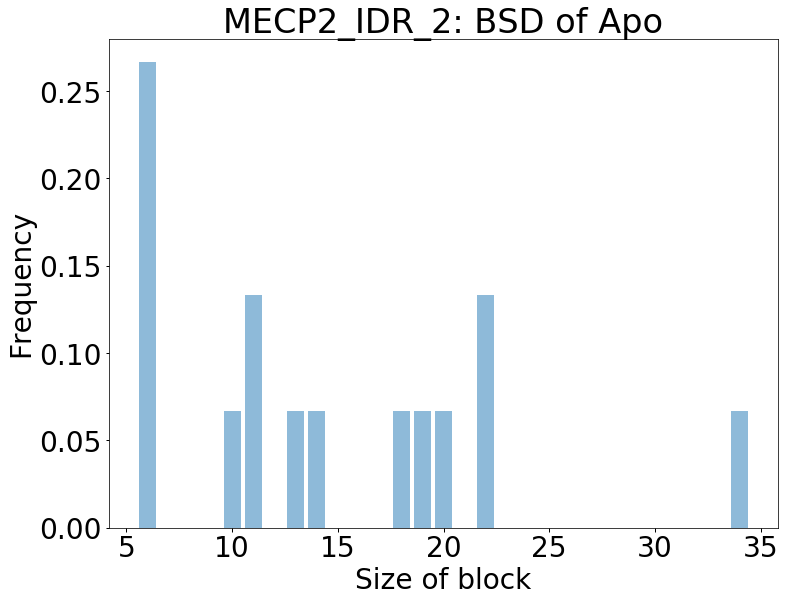

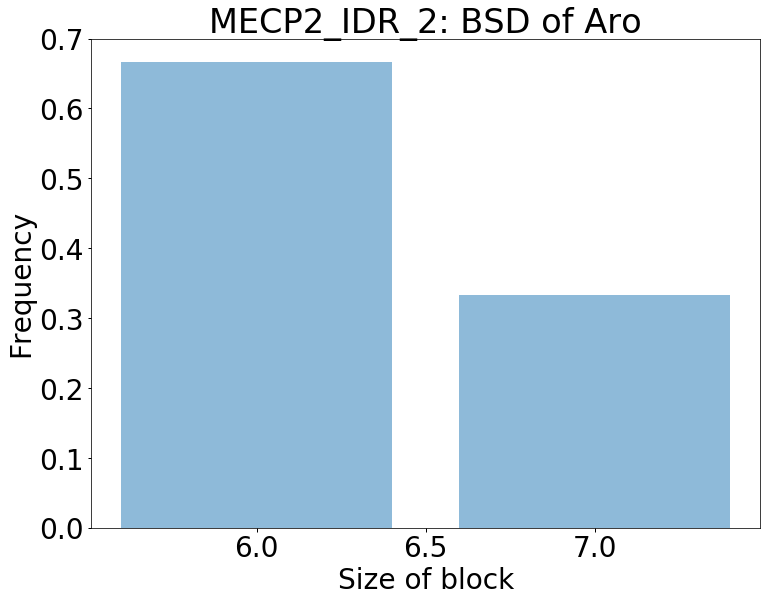

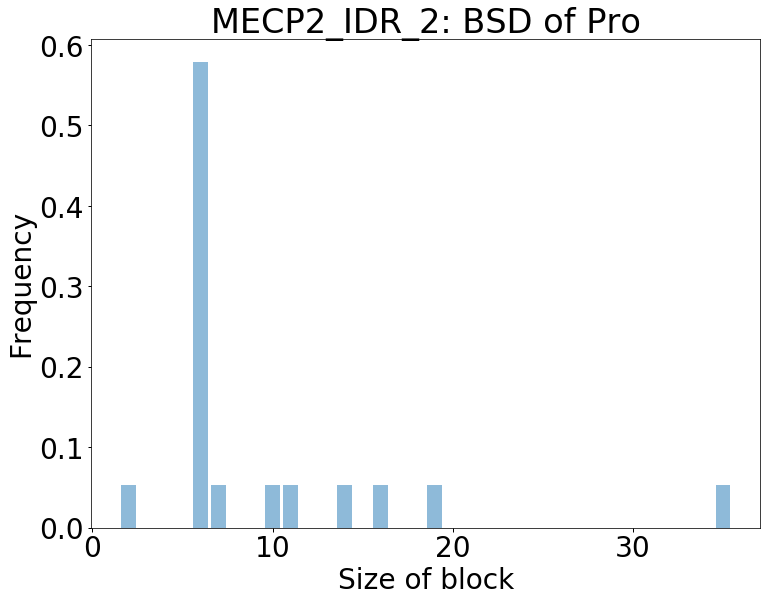

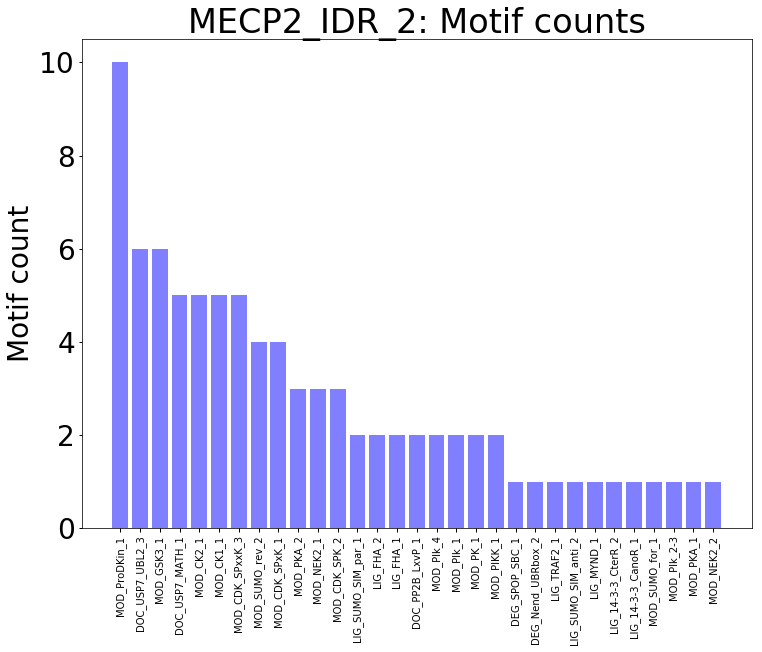

In [35]:
prot_names = ['BRD4', 'MECP2'] #all in capital letters!
fasta_file = filtered_filename
flag_single_bsd = 1
flag_cross_bsd = 0
flag_motifs = 1

dgen.plot_patterns(prot_names, fasta_file, Motif_filename, write_file_path, flag_save_files, coarse_graining, custom_aa_list, aa_group, aa_group_names, flag_single_bsd=flag_single_bsd, flag_cross_bsd=flag_cross_bsd, flag_motifs=flag_motifs)

In [36]:
#Getting the columns of the data matrix that correspond to these two proteins:

genes = [i for i in data_matrix.index]
genes_from_dm = [i.split('|')[2].split('_')[0] for i in data_matrix.index]
genes_from_dm = np.array(genes_from_dm)
print(len(genes_from_dm))

dm_lines_prots = pd.DataFrame(columns=data_matrix.columns)

for i in prot_names:
    inds_prots = list(np.where(genes_from_dm == i)[0])
    print(inds_prots)
    for j in inds_prots:
        dm_lines_prots.loc[data_matrix.index[j]] = (data_matrix.iloc[j,:])



10251
[969, 970, 971]
[2381, 2382]


In [37]:
dm_lines_prots

,f-NC,f-PC,f-Po,f-Apo,f-Aro,f-Pro,NC-P_small,NC-P_medium,NC-P_large,NC-l_avg,...,DEG_Nend_UBRbox_3,DEG_Nend_UBRbox_4,DEG_ODPH_VHL_1,DEG_SCF_FBW7_1,DEG_SCF_FBW7_2,DEG_SCF_SKP2-CKS1_1,DEG_SCF_TRCP1_1,DEG_SIAH_1,DEG_SPOP_SBC_1,label
O60885_1_1_59|BRD4_HUMAN|BRD4_HUMAN,0.288136,0.067797,0.084746,0.305085,0.389831,0.169492,0.000000,0.000000,1.000000,41.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O60885_2_169_351|BRD4_HUMAN|BRD4_HUMAN,0.262295,0.060109,0.142077,0.229508,0.284153,0.251366,0.555556,0.111111,0.333333,16.888889,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
O60885_3_456_1346|BRD4_HUMAN|BRD4_HUMAN,0.250281,0.115600,0.176207,0.367003,0.268238,0.189675,0.589744,0.256410,0.153846,16.717949,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
P51608_1_1_118|MECP2_HUMAN|MECP2_HUMAN,0.347458,0.169492,0.237288,0.330508,0.161017,0.084746,0.250000,0.250000,0.500000,25.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P51608_2_151_486|MECP2_HUMAN|MECP2_HUMAN,0.306548,0.113095,0.229167,0.252976,0.217262,0.133929,0.750000,0.125000,0.125000,34.625000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
